## Predictive Modelling and Interactive Dashboard for Cricket Match and Player Performance Analysis in the Indian Premier League (IPL)
## DA2-05 - Cricket Match and Player Analysis 
### University of Strathclyde, Glasgow, United Kingdom
#### Gowtham Kumar Mani Periyasamy - MSc Data Analytics – 202484847
#### Academic Supervisor : Dr Lindsey Corson


### Data Extraction and Parsing JSON

In [1]:
import os
import zipfile
import json
import pandas as pd

# --- STEP 1: Extract ZIP ---
zip_path = r"C:\Users\gauti\Downloads\ipl_json.zip"  # <- Your actual file
extract_path = r"C:\Users\gauti\Downloads\ipl_json_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# --- STEP 2: Parse JSON Files ---
matches_data = []
deliveries_data = []

for file_name in os.listdir(extract_path):
    if not file_name.endswith(".json"):
        continue

    file_path = os.path.join(extract_path, file_name)
    with open(file_path, 'r') as f:
        match_json = json.load(f)

    match_info = match_json.get("info", {})
    date = match_info.get("dates", [None])[0]

    if date is None or not (2018 <= int(date[:4]) <= 2025):
        continue

    match_id = file_name.replace(".json", "")
    matches_data.append({
        "match_id": match_id,
        "teams": match_info.get("teams", []),
        "venue": match_info.get("venue", ""),
        "city": match_info.get("city", ""),
        "date": date,
        "toss_winner": match_info.get("toss", {}).get("winner", ""),
        "toss_decision": match_info.get("toss", {}).get("decision", ""),
        "winner": match_info.get("outcome", {}).get("winner", None),
        "result": match_info.get("outcome", {}).get("result", None),
        "overs": match_info.get("overs", 20)
    })

    innings = match_json.get("innings", [])
    for inning in innings:
        if isinstance(inning, dict):
            team = inning.get("team", "")
            overs_data = inning.get("overs", [])
            if isinstance(overs_data, list):
                for over_data in overs_data:
                    over = over_data.get("over")
                    for delivery in over_data.get("deliveries", []):
                        if isinstance(delivery, dict):
                            deliveries_data.append({
                                "match_id": match_id,
                                "batting_team": team,
                                "over": over,
                                "batter": delivery.get("batter", ""),
                                "bowler": delivery.get("bowler", ""),
                                "non_striker": delivery.get("non_striker", ""),
                                "runs_batter": delivery.get("runs", {}).get("batter", 0),
                                "runs_extras": delivery.get("runs", {}).get("extras", 0),
                                "runs_total": delivery.get("runs", {}).get("total", 0),
                                "extras_type": list(delivery.get("extras", {}).keys())[0] if delivery.get("extras") else None,
                                "wicket_type": delivery.get("wickets", [{}])[0].get("kind", None) if delivery.get("wickets") else None,
                                "player_out": delivery.get("wickets", [{}])[0].get("player_out", None) if delivery.get("wickets") else None
                            })

# --- STEP 3: Create DataFrames ---
matches_df = pd.DataFrame(matches_data)
deliveries_df = pd.DataFrame(deliveries_data)


print("Parsed", len(matches_df), "matches and", len(deliveries_df), "deliveries.")





Parsed 533 matches and 127745 deliveries.


### Data Cleaning

In [2]:
# --- Step 3: Cleaning IPL Match and Delivery Data ---

import pandas as pd

#  1. Convert `date` to datetime
matches_df['date'] = pd.to_datetime(matches_df['date'])

#  2. Remove abandoned or 'no result' matches
matches_df = matches_df[matches_df['result'].isnull() | (matches_df['result'] != 'no result')]

#  3. Normalize team names
def normalize_team(name):
    if not isinstance(name, str):
        return name
    name = name.strip()
    replacements = {
        'Kings XI Punjab': 'Punjab Kings',
        'Delhi Daredevils': 'Delhi Capitals',
        'Rising Pune Supergiants': 'Rising Pune Supergiant',
    }
    return replacements.get(name, name)

matches_df['teams'] = matches_df['teams'].apply(lambda x: [normalize_team(t) for t in x])
matches_df['toss_winner'] = matches_df['toss_winner'].apply(normalize_team)
matches_df['winner'] = matches_df['winner'].apply(lambda x: normalize_team(x) if pd.notnull(x) else x)
deliveries_df['batting_team'] = deliveries_df['batting_team'].apply(normalize_team)

# Strip whitespace from player names
deliveries_df['batter'] = deliveries_df['batter'].str.strip()
deliveries_df['bowler'] = deliveries_df['bowler'].str.strip()
deliveries_df['non_striker'] = deliveries_df['non_striker'].str.strip()

#  4. Drop rows with missing critical fields
deliveries_df = deliveries_df.dropna(subset=['batter', 'bowler', 'batting_team'])

#  5. Create `ball_id` for over.ball format (e.g., 4.3)
deliveries_df['ball_id'] = deliveries_df['over'].astype(str) + '.' + deliveries_df.groupby('match_id')['over'].cumcount().astype(str)

#  (Optional) Reset index
matches_df.reset_index(drop=True, inplace=True)
deliveries_df.reset_index(drop=True, inplace=True)

print("Cleaning complete!")
print("Matches shape:", matches_df.shape)
print("Deliveries shape:", deliveries_df.shape)


Cleaning complete!
Matches shape: (528, 10)
Deliveries shape: (127745, 13)


In [3]:
# Import again if in a new cell
import pandas as pd

#  1. Top 10 Run Scorers
top_batters = (
    deliveries_df.groupby("batter")["runs_batter"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

#  2. Top 10 Wicket-Takers (excluding 'run out')
wickets_df = deliveries_df[deliveries_df['wicket_type'].notna()]
top_bowlers = (
    wickets_df[wickets_df['wicket_type'] != 'run out']
    .groupby("bowler")["player_out"]
    .count()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"player_out": "wickets"})
)

#  3. Toss Decision vs Match Winner
toss_vs_win = (
    matches_df.groupby("toss_decision")["winner"]
    .count()
    .reset_index()
    .rename(columns={"winner": "matches_won"})
)

#  4. Top 5 Venues with Most Matches
venue_counts = (
    matches_df["venue"]
    .value_counts()
    .head(5)
    .reset_index()
    .rename(columns={"index": "venue", "venue": "match_count"})
)

# 5. Total Matches Played Per Team
from collections import Counter
team_counter = Counter([team for teams in matches_df["teams"] for team in teams])
team_match_count = pd.DataFrame(team_counter.items(), columns=["team", "matches_played"]).sort_values(by="matches_played", ascending=False)

# Display all tables
print(" Top 10 Run Scorers")
print(top_batters)
print("\n Top 10 Wicket Takers")
print(top_bowlers)
print("\n Toss Decision vs Match Wins")
print(toss_vs_win)
print("\n Top 5 Venues by Match Count")
print(venue_counts)
print("\n Total Matches Played Per Team")
print(team_match_count)


 Top 10 Run Scorers
         batter  runs_batter
0      KL Rahul         4510
1       V Kohli         4248
2  Shubman Gill         3866
3      SA Yadav         3703
4    JC Buttler         3593
5  F du Plessis         3478
6     SV Samson         3278
7      S Dhawan         3208
8       RR Pant         3002
9       SS Iyer         2928

 Top 10 Wicket Takers
           bowler  wickets
0       YS Chahal      151
1     Rashid Khan      141
2       JJ Bumrah      140
3        TA Boult      128
4        HV Patel      117
5        K Rabada      116
6  Mohammed Shami      115
7        CV Varun      100
8  Mohammed Siraj      100
9  Arshdeep Singh       97

 Toss Decision vs Match Wins
  toss_decision  matches_won
0           bat          127
1         field          393

 Top 5 Venues by Match Count
                                match_count  count
0                  Wankhede Stadium, Mumbai     52
1       Dubai International Cricket Stadium     39
2  MA Chidambaram Stadium, Chepauk, Chenn

In [4]:
import pandas as pd

# --- Batting Stats ---

# Group by batter to compute aggregates
batting_stats = deliveries_df.groupby("batter").agg(
    runs_scored=("runs_batter", "sum"),
    balls_faced=("runs_batter", "count"),
    dot_balls=("runs_batter", lambda x: (x == 0).sum()),
    fours=("runs_batter", lambda x: (x == 4).sum()),
    sixes=("runs_batter", lambda x: (x == 6).sum())
).reset_index()

# Derived batting features
batting_stats["strike_rate"] = (batting_stats["runs_scored"] / batting_stats["balls_faced"]) * 100
batting_stats["dot_ball_pct"] = (batting_stats["dot_balls"] / batting_stats["balls_faced"]) * 100
batting_stats["boundary_pct"] = ((batting_stats["fours"] + batting_stats["sixes"]) / batting_stats["balls_faced"]) * 100

# Filter for batters with at least 200 balls faced
batting_stats = batting_stats[batting_stats["balls_faced"] >= 200]
batting_stats = batting_stats.sort_values(by="runs_scored", ascending=False)

# --- Bowling Stats ---

# Filter deliveries where a wicket (except run out) was taken
wickets_df = deliveries_df[deliveries_df["wicket_type"].notna() & (deliveries_df["wicket_type"] != "run out")]

# Group by bowler to compute aggregates
bowling_stats = deliveries_df.groupby("bowler").agg(
    runs_conceded=("runs_total", "sum"),
    balls_bowled=("runs_total", "count"),
    dot_balls=("runs_total", lambda x: (x == 0).sum())
).reset_index()

# Add wickets
bowler_wickets = wickets_df.groupby("bowler")["player_out"].count().reset_index().rename(columns={"player_out": "wickets"})
bowling_stats = pd.merge(bowling_stats, bowler_wickets, on="bowler", how="left").fillna(0)

# Derived bowling features
bowling_stats["overs"] = bowling_stats["balls_bowled"] // 6
bowling_stats["economy"] = bowling_stats["runs_conceded"] / bowling_stats["overs"].replace(0, 1)
bowling_stats["dot_ball_pct"] = (bowling_stats["dot_balls"] / bowling_stats["balls_bowled"]) * 100

# Filter for bowlers with at least 120 balls bowled (20 overs)
bowling_stats = bowling_stats[bowling_stats["balls_bowled"] >= 120]
bowling_stats = bowling_stats.sort_values(by="wickets", ascending=False)

# --- Output Summary ---
print(" Batter Stats (min 200 balls):", batting_stats.shape)
print(" Bowler Stats (min 20 overs):", bowling_stats.shape)


 Batter Stats (min 200 balls): (126, 9)
 Bowler Stats (min 20 overs): (180, 8)


In [5]:
import pandas as pd

# --- STEP 1: Tag Phase per Delivery ---
def classify_phase(over):
    if 0 <= over <= 5:
        return "Powerplay"
    elif 6 <= over <= 15:
        return "Middle"
    else:
        return "Death"

deliveries_df["phase"] = deliveries_df["over"].apply(classify_phase)

# --- STEP 2: Phase-wise Batting Stats ---
phase_batting = (
    deliveries_df.groupby(["batter", "phase"])
    .agg(
        runs=("runs_batter", "sum"),
        balls=("runs_batter", "count"),
        dot_balls=("runs_batter", lambda x: (x == 0).sum()),
        fours=("runs_batter", lambda x: (x == 4).sum()),
        sixes=("runs_batter", lambda x: (x == 6).sum())
    )
    .reset_index()
)

# Derived features for batters
phase_batting["strike_rate"] = (phase_batting["runs"] / phase_batting["balls"]) * 100
phase_batting["dot_ball_pct"] = (phase_batting["dot_balls"] / phase_batting["balls"]) * 100
phase_batting["boundary_pct"] = ((phase_batting["fours"] + phase_batting["sixes"]) / phase_batting["balls"]) * 100

# Filter: min 100 balls faced per phase
phase_batting_filtered = phase_batting[phase_batting["balls"] >= 100]

# --- STEP 3: Phase-wise Bowling Stats ---
phase_bowling = (
    deliveries_df.groupby(["bowler", "phase"])
    .agg(
        runs_conceded=("runs_total", "sum"),
        balls_bowled=("runs_total", "count"),
        dot_balls=("runs_total", lambda x: (x == 0).sum())
    )
    .reset_index()
)

# Add wickets per phase (excluding run outs)
wickets_by_phase = (
    deliveries_df[deliveries_df["wicket_type"].notna() & (deliveries_df["wicket_type"] != "run out")]
    .groupby(["bowler", "phase"])["player_out"]
    .count()
    .reset_index()
    .rename(columns={"player_out": "wickets"})
)

# Merge and compute derived features
phase_bowling = pd.merge(phase_bowling, wickets_by_phase, on=["bowler", "phase"], how="left").fillna(0)
phase_bowling["overs"] = phase_bowling["balls_bowled"] // 6
phase_bowling["economy"] = phase_bowling["runs_conceded"] / phase_bowling["overs"].replace(0, 1)
phase_bowling["dot_ball_pct"] = (phase_bowling["dot_balls"] / phase_bowling["balls_bowled"]) * 100

# Filter: min 60 balls bowled per phase
phase_bowling_filtered = phase_bowling[phase_bowling["balls_bowled"] >= 60]

# --- OPTIONAL: Display summary shapes ---
print(" Phase-wise Batting Stats:", phase_batting_filtered.shape)
print(" Phase-wise Bowling Stats:", phase_bowling_filtered.shape)

# --- OPTIONAL: Save to CSV ---
# phase_batting_filtered.to_csv("phasewise_batting.csv", index=False)
# phase_bowling_filtered.to_csv("phasewise_bowling.csv", index=False)


 Phase-wise Batting Stats: (263, 10)
 Phase-wise Bowling Stats: (386, 9)


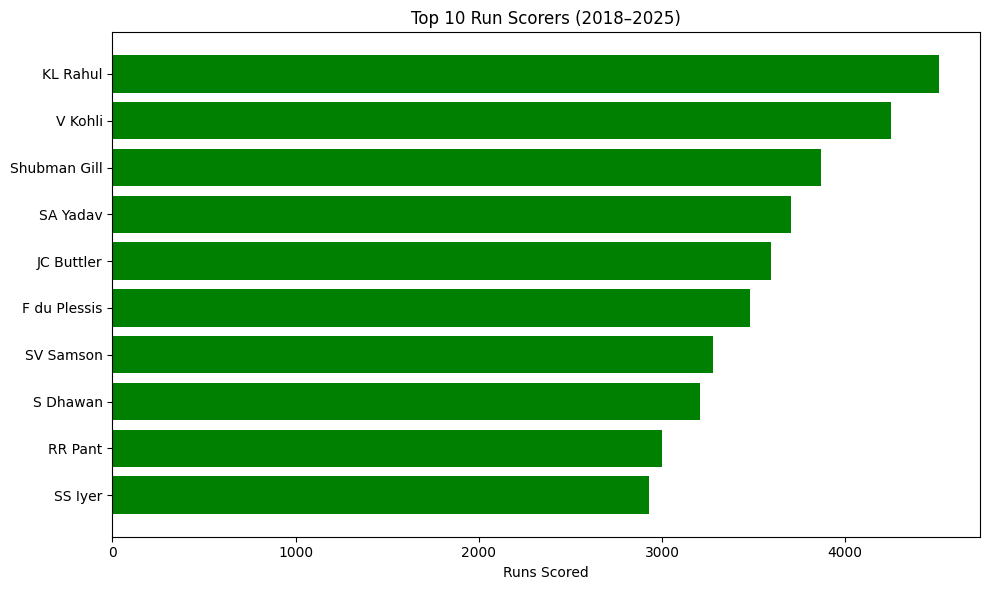

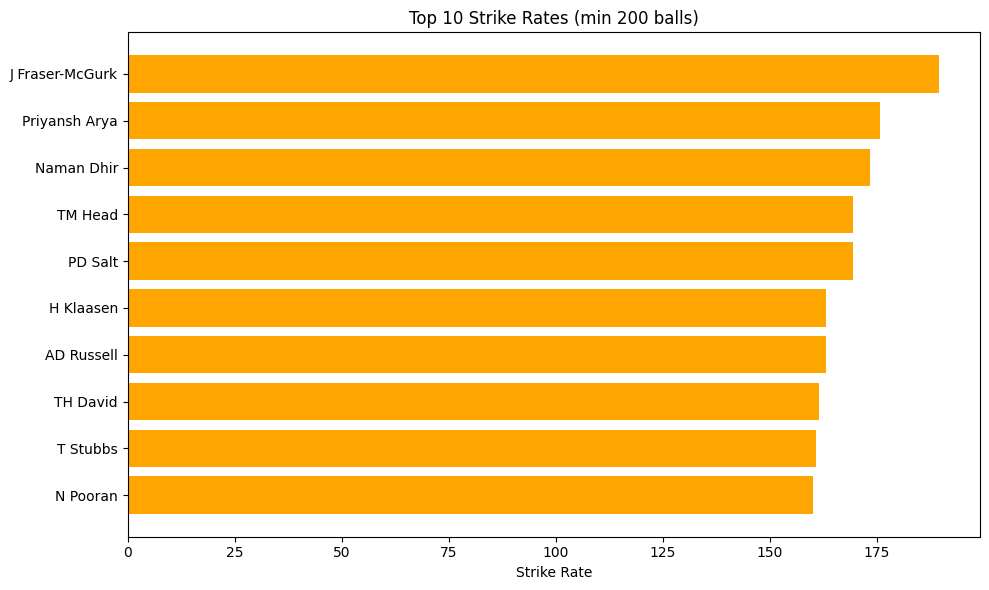

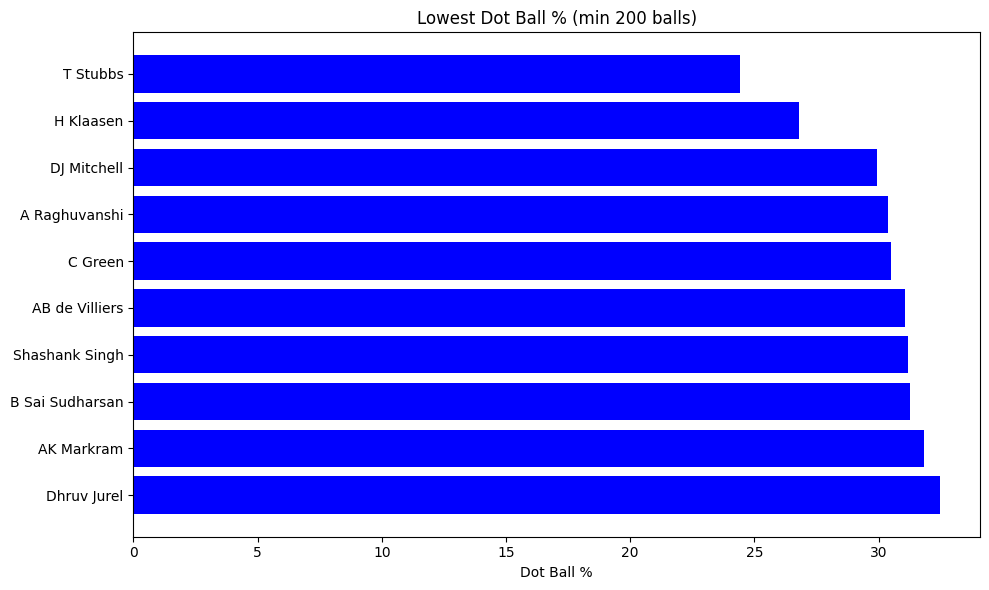

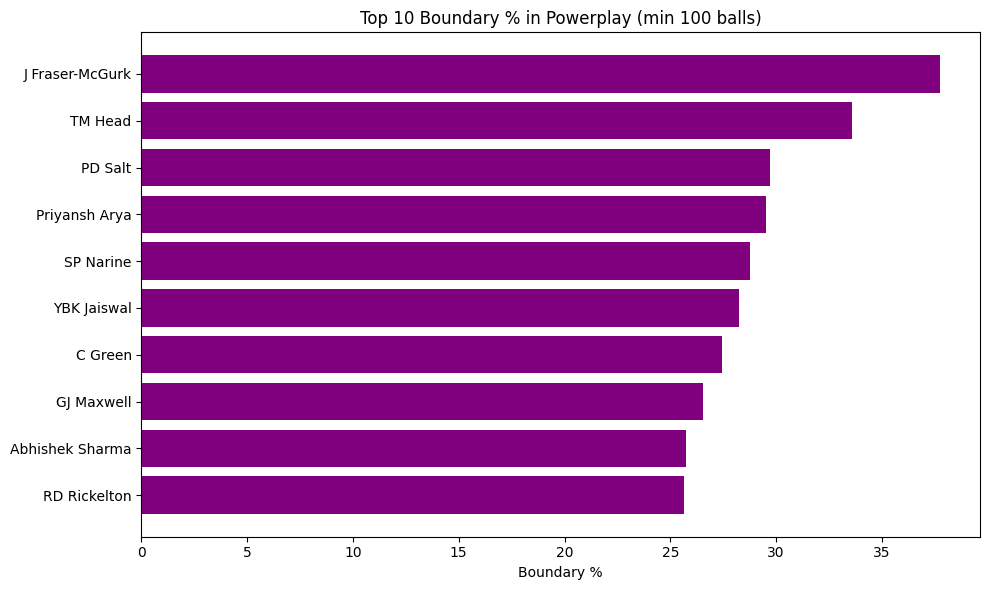

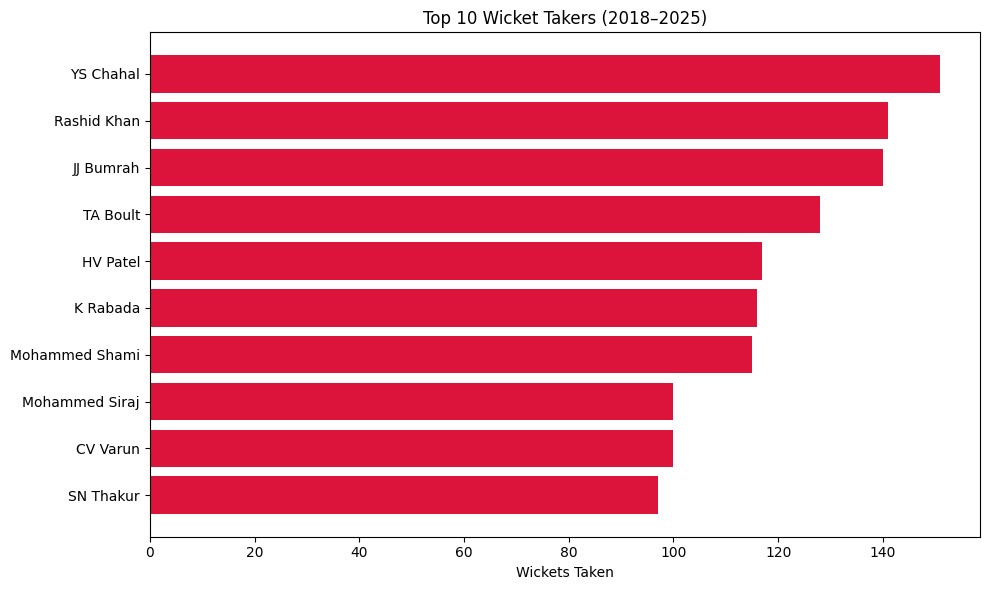

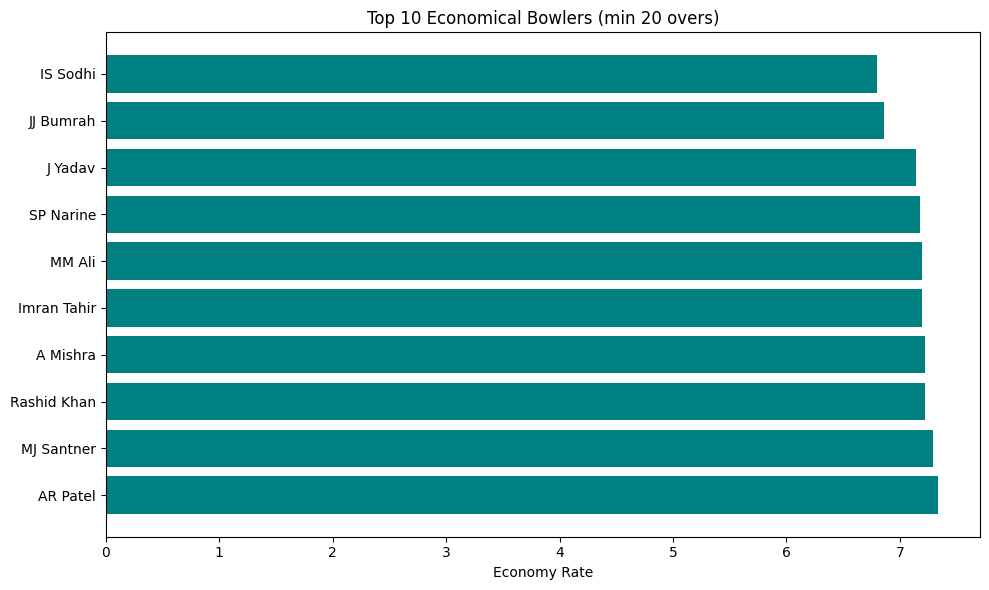

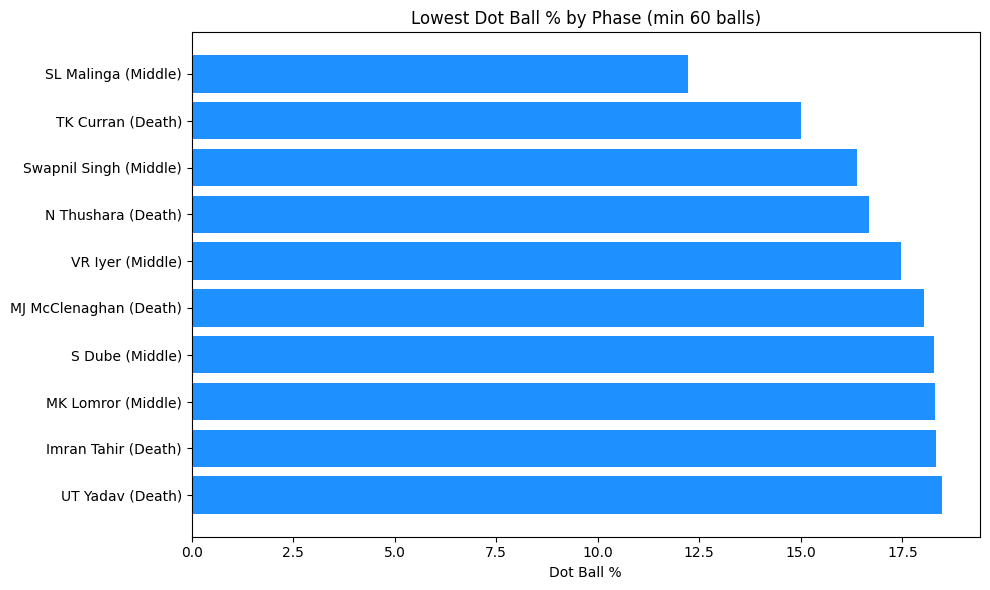

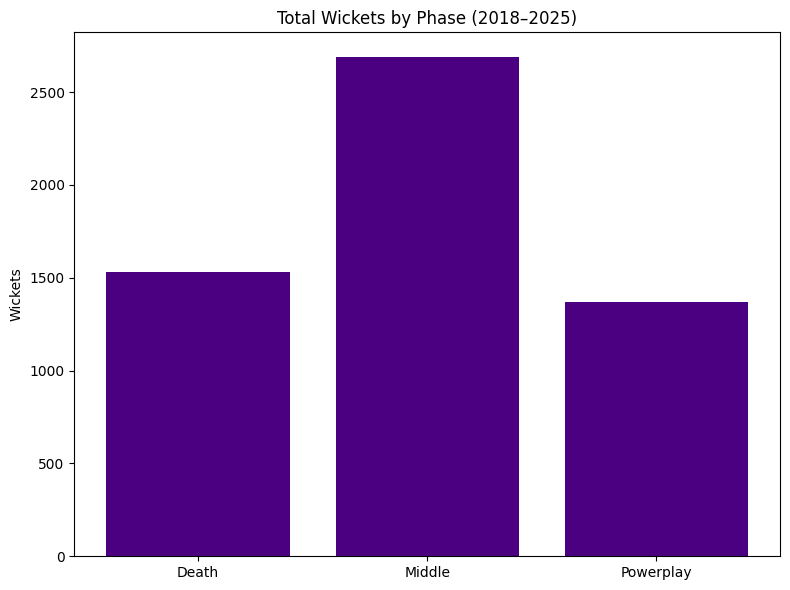

C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\1761521900.py:112: UserWarning: Glyph 127951 (\N{CRICKET BAT AND BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gauti\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127951 (\N{CRICKET BAT AND BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


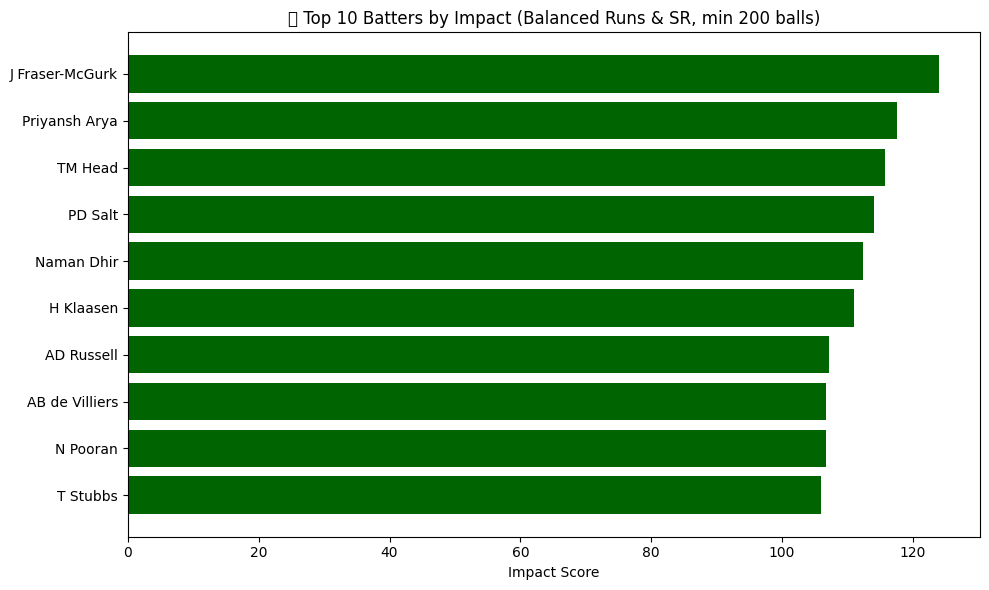

C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\1761521900.py:128: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gauti\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


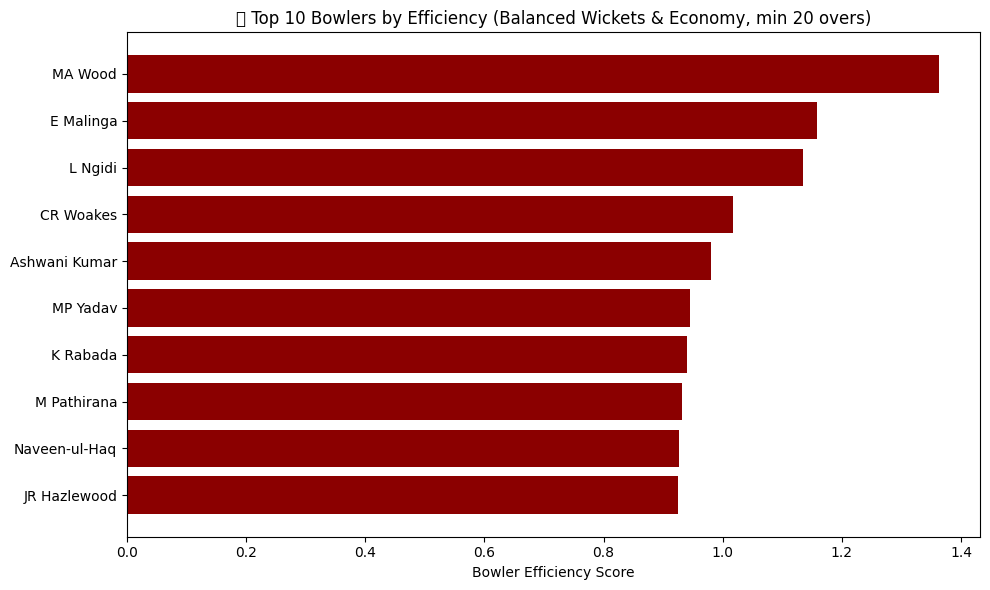

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# ---------- BATTER VISUALIZATIONS ----------

# 1. Top 10 Run Scorers
top10_runs = batting_stats.sort_values(by="runs_scored", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10_runs["batter"], top10_runs["runs_scored"], color='green')
plt.xlabel("Runs Scored")
plt.title("Top 10 Run Scorers (2018–2025)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Highest Strike Rates (min 200 balls)
top10_sr = batting_stats.sort_values(by="strike_rate", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10_sr["batter"], top10_sr["strike_rate"], color='orange')
plt.xlabel("Strike Rate")
plt.title("Top 10 Strike Rates (min 200 balls)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. Lowest Dot Ball % (min 200 balls)
lowest_dot_pct = batting_stats.sort_values(by="dot_ball_pct").head(10)
plt.figure(figsize=(10, 6))
plt.barh(lowest_dot_pct["batter"], lowest_dot_pct["dot_ball_pct"], color='blue')
plt.xlabel("Dot Ball %")
plt.title("Lowest Dot Ball % (min 200 balls)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4. Top Boundary % in Powerplay
pp_boundary = phase_batting_filtered[phase_batting_filtered["phase"] == "Powerplay"]
top_boundary_pp = pp_boundary.sort_values(by="boundary_pct", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_boundary_pp["batter"], top_boundary_pp["boundary_pct"], color='purple')
plt.xlabel("Boundary %")
plt.title("Top 10 Boundary % in Powerplay (min 100 balls)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ---------- BOWLER VISUALIZATIONS ----------

# 1. Top 10 Wicket Takers
top10_wickets = bowling_stats.sort_values(by="wickets", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10_wickets["bowler"], top10_wickets["wickets"], color='crimson')
plt.xlabel("Wickets Taken")
plt.title("Top 10 Wicket Takers (2018–2025)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Best Economy Rate (min 20 overs)
best_economy = bowling_stats.sort_values(by="economy").head(10)
plt.figure(figsize=(10, 6))
plt.barh(best_economy["bowler"], best_economy["economy"], color='teal')
plt.xlabel("Economy Rate")
plt.title("Top 10 Economical Bowlers (min 20 overs)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. Lowest Dot Ball % by Phase
best_dot_phase = phase_bowling_filtered.sort_values(by="dot_ball_pct").head(10)
plt.figure(figsize=(10, 6))
plt.barh(best_dot_phase["bowler"] + ' (' + best_dot_phase["phase"] + ')',
         best_dot_phase["dot_ball_pct"], color='dodgerblue')
plt.xlabel("Dot Ball %")
plt.title("Lowest Dot Ball % by Phase (min 60 balls)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 4. Total Wickets by Phase
wicket_phase_sum = phase_bowling_filtered.groupby("phase")["wickets"].sum().reset_index()
plt.figure(figsize=(8, 6))
plt.bar(wicket_phase_sum["phase"], wicket_phase_sum["wickets"], color='indigo')
plt.ylabel("Wickets")
plt.title("Total Wickets by Phase (2018–2025)")
plt.tight_layout()
plt.show()

# ---------- ADD MATCHES PLAYED (to normalize player stats) ----------

# Compute Matches Played for Batters
batter_matches = deliveries_df.groupby("batter")["match_id"].nunique().reset_index(name="matches_played")
batting_stats = batting_stats.merge(batter_matches, on="batter", how="left")

# Compute Matches Played for Bowlers
bowler_matches = deliveries_df.groupby("bowler")["match_id"].nunique().reset_index(name="matches_played")
bowling_stats = bowling_stats.merge(bowler_matches, on="bowler", how="left")

# ---------- FAIR BATTER RANKINGS ----------
# Filter batters with at least 200 balls faced
batting_filtered = batting_stats[batting_stats["balls_faced"] >= 200].copy()
batting_filtered["runs_per_match"] = batting_filtered["runs_scored"] / batting_filtered["matches_played"]
batting_filtered["impact_score"] = (batting_filtered["strike_rate"] * 0.6) + (batting_filtered["runs_per_match"] * 0.4)

# 1. Top 10 Batters by Impact Score
top10_impact = batting_filtered.sort_values(by="impact_score", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10_impact["batter"], top10_impact["impact_score"], color='darkgreen')
plt.xlabel("Impact Score")
plt.title("🏏 Top 10 Batters by Impact (Balanced Runs & SR, min 200 balls)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ---------- FAIR BOWLER RANKINGS ----------
# Filter bowlers with at least 120 balls (20 overs)
bowling_filtered = bowling_stats[bowling_stats["balls_bowled"] >= 120].copy()
bowling_filtered["wickets_per_match"] = bowling_filtered["wickets"] / bowling_filtered["matches_played"]
bowling_filtered["bowler_efficiency"] = (bowling_filtered["wickets_per_match"] * 0.6) + ((1 / bowling_filtered["economy"]) * 0.4)

# 1. Top 10 Bowlers by Efficiency
top10_eff = bowling_filtered.sort_values(by="bowler_efficiency", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10_eff["bowler"], top10_eff["bowler_efficiency"], color='darkred')
plt.xlabel("Bowler Efficiency Score")
plt.title("🎯 Top 10 Bowlers by Efficiency (Balanced Wickets & Economy, min 20 overs)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\3682815310.py:143: UserWarning: Glyph 127951 (\N{CRICKET BAT AND BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gauti\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127951 (\N{CRICKET BAT AND BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


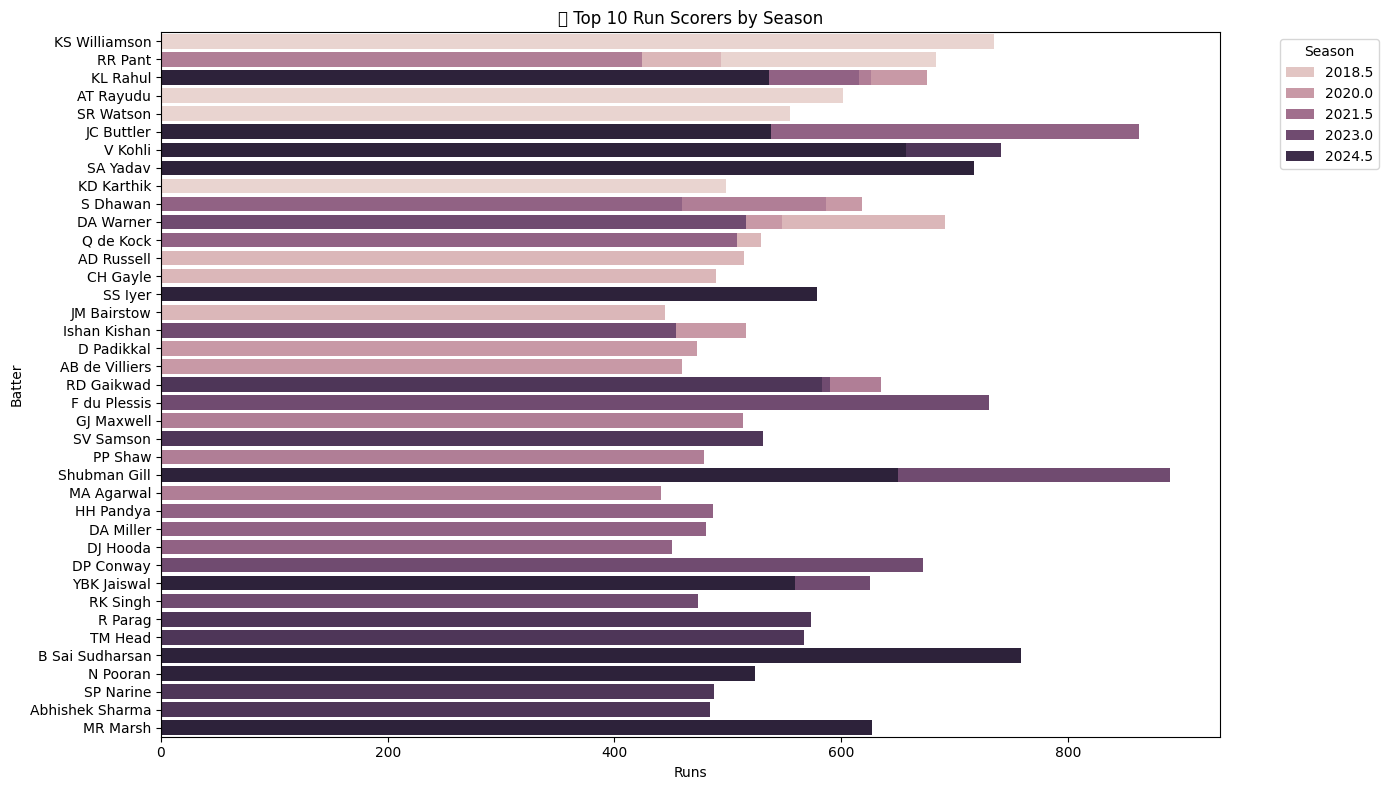

C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\3682815310.py:153: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gauti\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


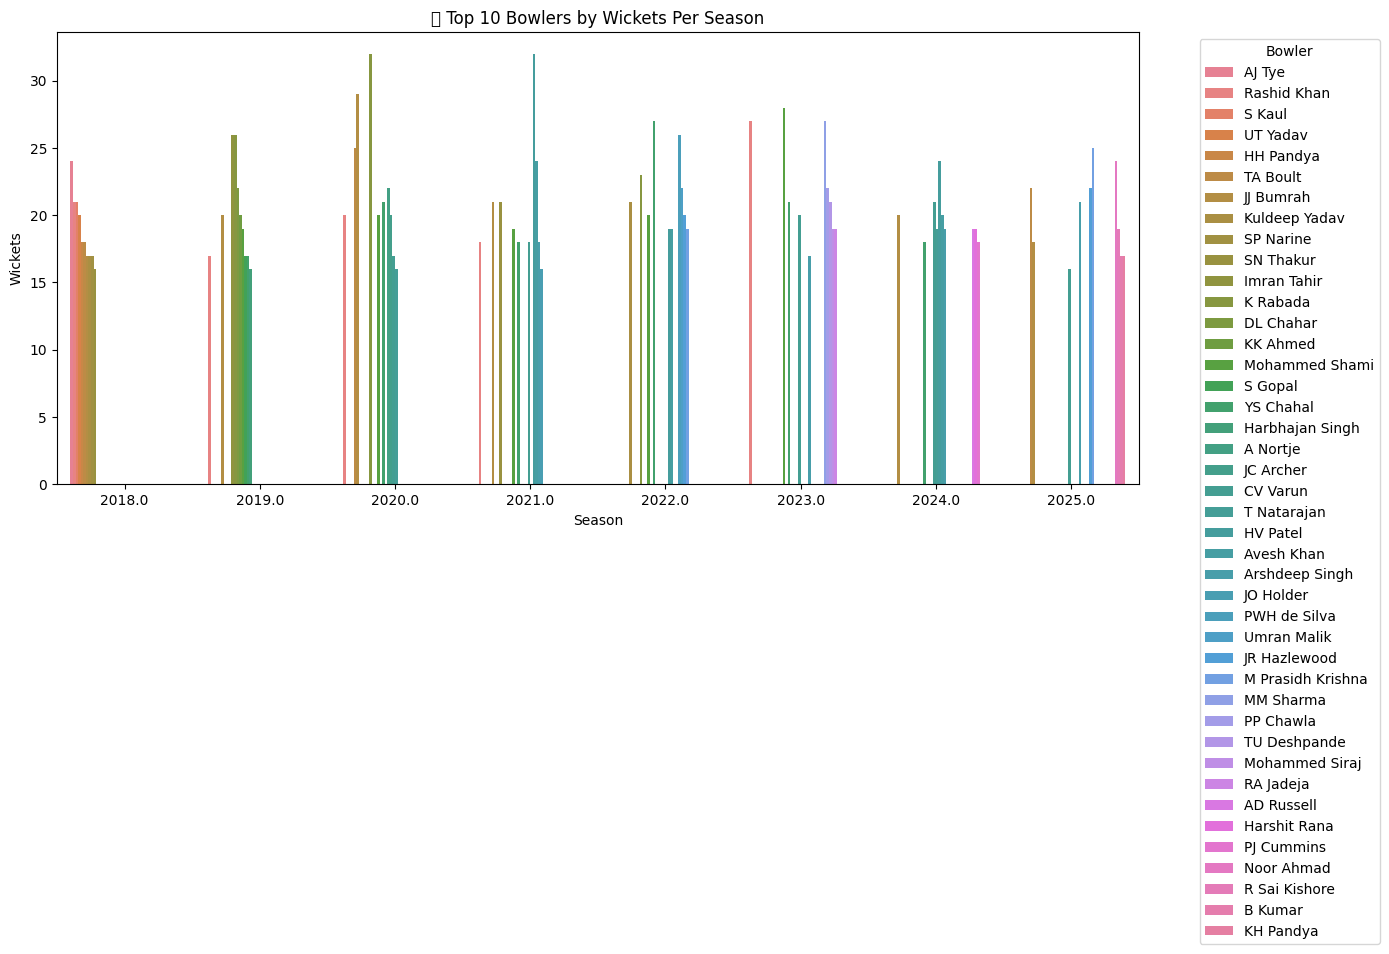

C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\3682815310.py:163: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gauti\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


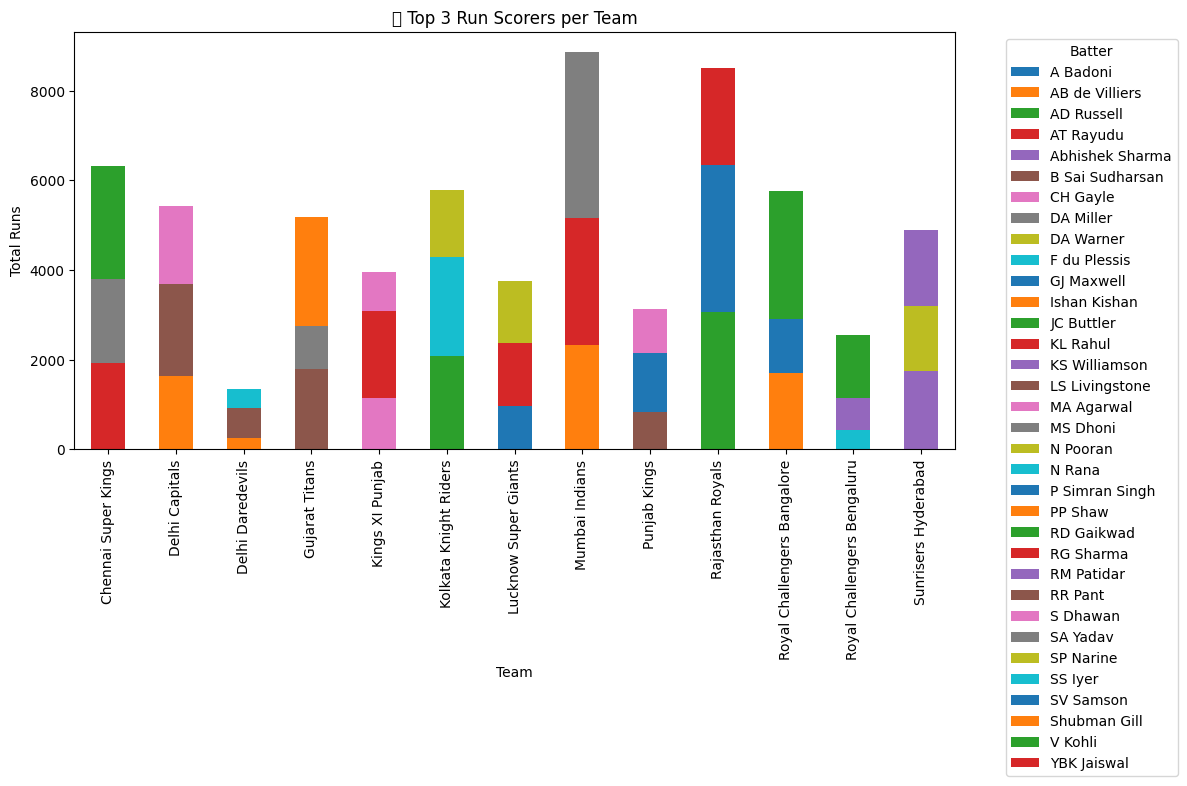

C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\3682815310.py:173: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gauti\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


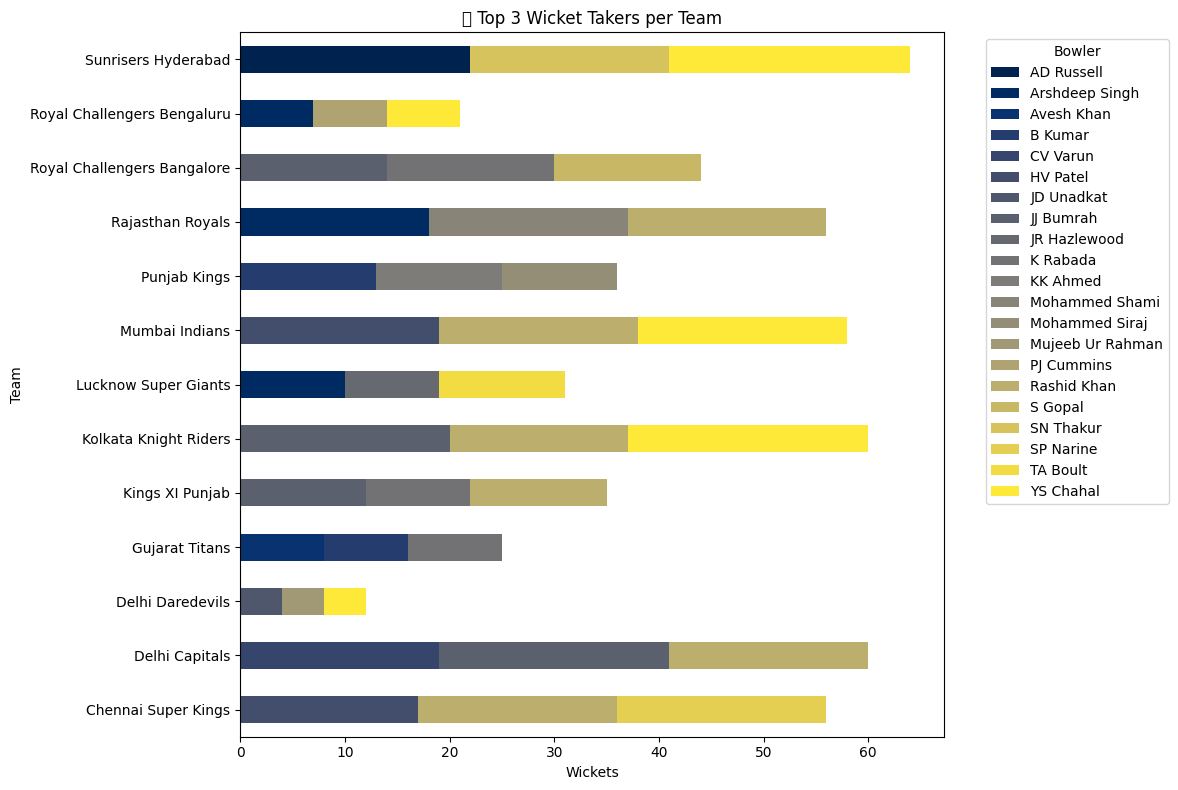

C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\3682815310.py:182: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gauti\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


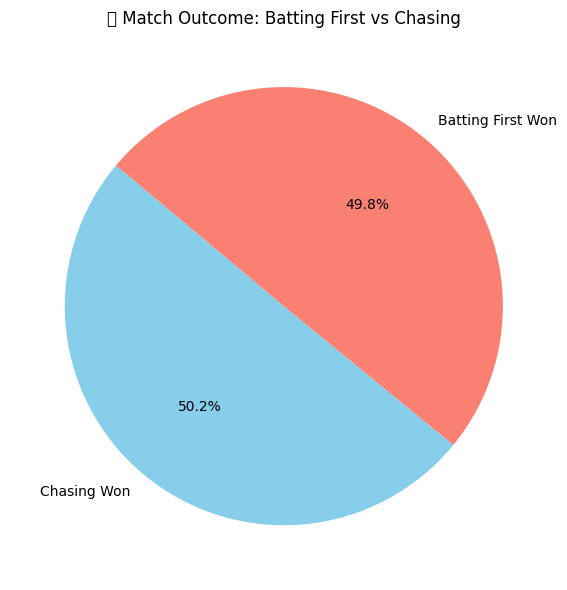

In [7]:
import os
import json
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Unzip IPL JSON data
zip_path = r"C:\Users\gauti\Downloads\ipl_json.zip"  
extract_path = r"C:\Users\gauti\Downloads\ipl_json_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 2: Parse JSON files
matches_data = []
deliveries_data = []

for file_name in os.listdir(extract_path):
    if not file_name.endswith(".json"):
        continue

    with open(os.path.join(extract_path, file_name)) as f:
        match_json = json.load(f)

    match_info = match_json.get("info", {})
    date = match_info.get("dates", [None])[0]
    if date is None or not (2018 <= int(date[:4]) <= 2025):
        continue

    match_id = file_name.replace(".json", "")
    matches_data.append({
        "match_id": match_id,
        "teams": match_info.get("teams", []),
        "venue": match_info.get("venue", ""),
        "city": match_info.get("city", ""),
        "date": date,
        "toss_winner": match_info.get("toss", {}).get("winner", ""),
        "toss_decision": match_info.get("toss", {}).get("decision", ""),
        "winner": match_info.get("outcome", {}).get("winner", None),
        "result": match_info.get("outcome", {}).get("result", None),
        "overs": match_info.get("overs", 20)
    })

    for inning in match_json.get("innings", []):
        team = inning.get("team", "")
        for over_data in inning.get("overs", []):
            over = over_data.get("over")
            for delivery in over_data.get("deliveries", []):
                deliveries_data.append({
                    "match_id": match_id,
                    "batting_team": team,
                    "over": over,
                    "batter": delivery.get("batter", ""),
                    "bowler": delivery.get("bowler", ""),
                    "non_striker": delivery.get("non_striker", ""),
                    "runs_batter": delivery.get("runs", {}).get("batter", 0),
                    "runs_extras": delivery.get("runs", {}).get("extras", 0),
                    "runs_total": delivery.get("runs", {}).get("total", 0),
                    "extras_type": list(delivery.get("extras", {}).keys())[0] if delivery.get("extras") else None,
                    "wicket_type": delivery.get("wickets", [{}])[0].get("kind", None) if delivery.get("wickets") else None,
                    "player_out": delivery.get("wickets", [{}])[0].get("player_out", None) if delivery.get("wickets") else None
                })

matches_df = pd.DataFrame(matches_data)
deliveries_df = pd.DataFrame(deliveries_data)

# Step 3: Clean & prepare
matches_df['date'] = pd.to_datetime(matches_df['date'])
matches_df = matches_df[matches_df['result'].isnull() | (matches_df['result'] != 'no result')]
deliveries_df = deliveries_df.dropna(subset=['batter', 'bowler', 'batting_team'])
matches_df['season'] = matches_df['date'].dt.year
deliveries_df = deliveries_df.merge(matches_df[['match_id', 'season']], on='match_id', how='left')

# Step 4: Season-wise & Team-wise Analysis
# 1. Top 10 batters per season
season_top_batters = (
    deliveries_df.groupby(['season', 'batter'])['runs_batter']
    .sum()
    .reset_index()
    .sort_values(['season', 'runs_batter'], ascending=[True, False])
    .groupby('season')
    .head(10)
)

# 2. Top 10 bowlers per season (exclude run outs)
wickets_df = deliveries_df[deliveries_df["wicket_type"].notna() & (deliveries_df["wicket_type"] != "run out")]
season_top_bowlers = (
    wickets_df.groupby(['season', 'bowler'])['player_out']
    .count()
    .reset_index()
    .sort_values(['season', 'player_out'], ascending=[True, False])
    .groupby('season')
    .head(10)
)

# 3. Top 3 batters per team
team_batting = deliveries_df.groupby(['batting_team', 'batter'])['runs_batter'].sum().reset_index()
team_top_batters = (
    team_batting.sort_values(['batting_team', 'runs_batter'], ascending=[True, False])
    .groupby('batting_team')
    .head(3)
)

# 4. Top 3 bowlers per team
team_wickets = wickets_df.groupby(['batting_team', 'bowler'])['player_out'].count().reset_index()
team_top_bowlers = (
    team_wickets.sort_values(['batting_team', 'player_out'], ascending=[True, False])
    .groupby('batting_team')
    .head(3)
)

# 5. Batting first win stats
match_first_innings = (
    deliveries_df.groupby(['match_id', 'batting_team'])
    .first()
    .reset_index()
    .groupby('match_id')
    .first()
    .reset_index()[['match_id', 'batting_team']]
    .rename(columns={'batting_team': 'team_batted_first'})
)

matches_with_first = matches_df.merge(match_first_innings, on='match_id', how='left')
matches_with_first['bat_first_win'] = matches_with_first['team_batted_first'] == matches_with_first['winner']
batting_first_summary = matches_with_first['bat_first_win'].value_counts(normalize=True).rename_axis('batting_first_won').reset_index(name='percentage')

# Save tables to CSV
season_top_batters.to_csv("season_top_batters.csv", index=False)
season_top_bowlers.to_csv("season_top_bowlers.csv", index=False)
team_top_batters.to_csv("team_top_batters.csv", index=False)
team_top_bowlers.to_csv("team_top_bowlers.csv", index=False)
batting_first_summary.to_csv("batting_first_summary.csv", index=False)

# Step 5: Visualizations
# Season-wise Top 10 Batters
plt.figure(figsize=(14, 8))
sns.barplot(data=season_top_batters, x='runs_batter', y='batter', hue='season', dodge=False)
plt.title("🏏 Top 10 Run Scorers by Season")
plt.xlabel("Runs")
plt.ylabel("Batter")
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Updated Season-wise Top Bowlers (grouped bar)
plt.figure(figsize=(14, 8))
sns.barplot(data=season_top_bowlers, x='season', y='player_out', hue='bowler')
plt.title("🎯 Top 10 Bowlers by Wickets Per Season")
plt.ylabel("Wickets")
plt.xlabel("Season")
plt.legend(title="Bowler", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 3 Batters per Team - Stacked
batter_pivot = team_top_batters.pivot(index="batting_team", columns="batter", values="runs_batter").fillna(0)
batter_pivot.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title("🏆 Top 3 Run Scorers per Team")
plt.ylabel("Total Runs")
plt.xlabel("Team")
plt.legend(title="Batter", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Top 3 Bowlers per Team - Horizontal Stacked
bowler_pivot = team_top_bowlers.pivot(index="batting_team", columns="bowler", values="player_out").fillna(0)
bowler_pivot.plot(kind='barh', stacked=True, figsize=(12, 8), colormap="cividis")
plt.title("🔥 Top 3 Wicket Takers per Team")
plt.xlabel("Wickets")
plt.ylabel("Team")
plt.legend(title="Bowler", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Batting First vs Chasing - Pie Chart
labels = ["Chasing Won", "Batting First Won"]
sizes = batting_first_summary['percentage'].tolist()
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=["skyblue", "salmon"])
plt.title("🏁 Match Outcome: Batting First vs Chasing")
plt.tight_layout()
plt.show()


In [8]:
# Re-import after session reset
import os
import json
import zipfile
import pandas as pd

# Reload ZIP and parse data
zip_path = r"C:\Users\gauti\Downloads\ipl_json.zip"  
extract_path = r"C:\Users\gauti\Downloads\ipl_json_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

matches_data = []
deliveries_data = []

for file_name in os.listdir(extract_path):
    if not file_name.endswith(".json"):
        continue

    with open(os.path.join(extract_path, file_name)) as f:
        match_json = json.load(f)

    match_info = match_json.get("info", {})
    date = match_info.get("dates", [None])[0]
    if date is None or not (2018 <= int(date[:4]) <= 2025):
        continue

    match_id = file_name.replace(".json", "")
    matches_data.append({
        "match_id": match_id,
        "teams": match_info.get("teams", []),
        "venue": match_info.get("venue", ""),
        "city": match_info.get("city", ""),
        "date": date,
        "toss_winner": match_info.get("toss", {}).get("winner", ""),
        "toss_decision": match_info.get("toss", {}).get("decision", ""),
        "winner": match_info.get("outcome", {}).get("winner", None),
        "result": match_info.get("outcome", {}).get("result", None),
        "overs": match_info.get("overs", 20)
    })

    for inning in match_json.get("innings", []):
        team = inning.get("team", "")
        for over_data in inning.get("overs", []):
            over = over_data.get("over")
            for delivery in over_data.get("deliveries", []):
                deliveries_data.append({
                    "match_id": match_id,
                    "batting_team": team,
                    "over": over,
                    "batter": delivery.get("batter", ""),
                    "bowler": delivery.get("bowler", ""),
                    "non_striker": delivery.get("non_striker", ""),
                    "runs_batter": delivery.get("runs", {}).get("batter", 0),
                    "runs_extras": delivery.get("runs", {}).get("extras", 0),
                    "runs_total": delivery.get("runs", {}).get("total", 0),
                    "extras_type": list(delivery.get("extras", {}).keys())[0] if delivery.get("extras") else None,
                    "wicket_type": delivery.get("wickets", [{}])[0].get("kind", None) if delivery.get("wickets") else None,
                    "player_out": delivery.get("wickets", [{}])[0].get("player_out", None) if delivery.get("wickets") else None
                })

matches_df = pd.DataFrame(matches_data)
deliveries_df = pd.DataFrame(deliveries_data)

# Clean
matches_df['date'] = pd.to_datetime(matches_df['date'])
matches_df = matches_df[matches_df['result'].isnull() | (matches_df['result'] != 'no result')]
deliveries_df = deliveries_df.dropna(subset=['batter', 'bowler', 'batting_team'])
matches_df['season'] = matches_df['date'].dt.year
deliveries_df = deliveries_df.merge(matches_df[['match_id', 'season']], on='match_id', how='left')

# Get wickets df
wickets_df = deliveries_df[deliveries_df["wicket_type"].notna() & (deliveries_df["wicket_type"] != "run out")]

# Team-wise best batter and bowler per season
team_season_bat = (
    deliveries_df.groupby(['season', 'batting_team', 'batter'])['runs_batter']
    .sum()
    .reset_index()
)

top_batter_by_team_season = (
    team_season_bat.sort_values(['season', 'batting_team', 'runs_batter'], ascending=[True, True, False])
    .groupby(['season', 'batting_team'])
    .first()
    .reset_index()
    .rename(columns={'batter': 'top_batter', 'runs_batter': 'total_runs'})
)

team_season_bowl = (
    wickets_df.groupby(['season', 'batting_team', 'bowler'])['player_out']
    .count()
    .reset_index()
)

top_bowler_by_team_season = (
    team_season_bowl.sort_values(['season', 'batting_team', 'player_out'], ascending=[True, True, False])
    .groupby(['season', 'batting_team'])
    .first()
    .reset_index()
    .rename(columns={'bowler': 'top_bowler', 'player_out': 'total_wickets'})
)

team_season_performance = pd.merge(top_batter_by_team_season, top_bowler_by_team_season, on=['season', 'batting_team'], how='outer')





### Best Finishers, Team Won the Championship, Death Bowlers

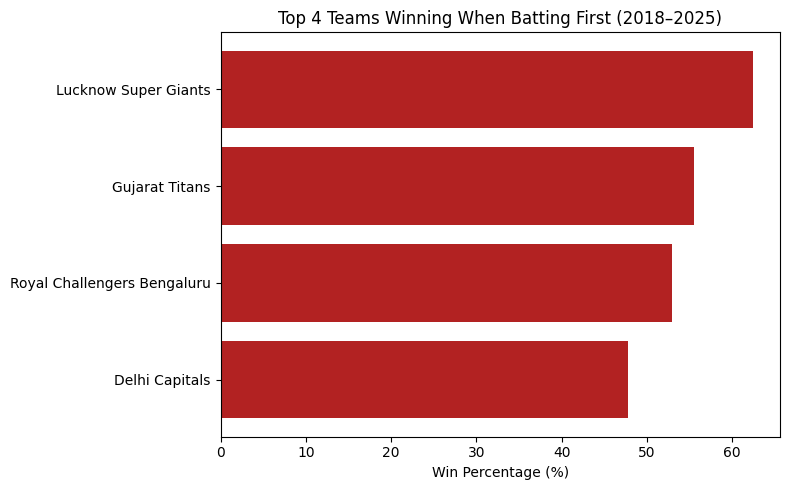

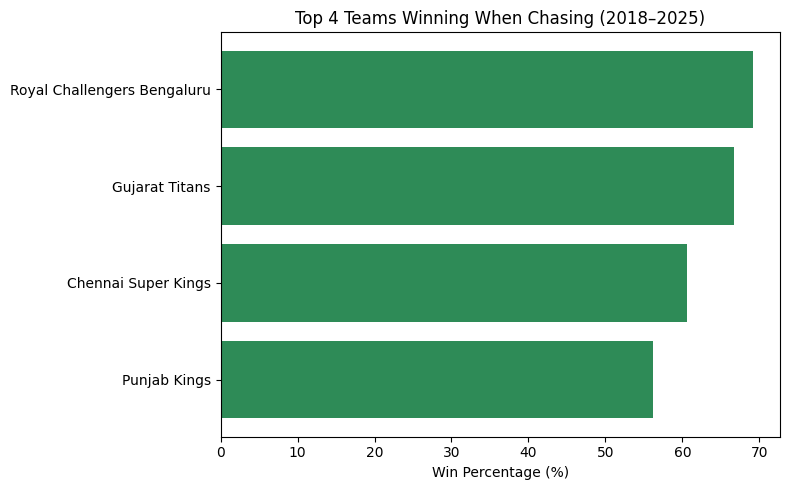

In [9]:
# ---------- TEAM-WISE WIN PERCENTAGE: BATTING FIRST VS SECOND ----------
import numpy as np
# ✅ Ensure columns exist
if 'home_team' not in matches_df.columns or 'away_team' not in matches_df.columns:
    matches_df['home_team'] = matches_df['teams'].apply(lambda x: x[0] if isinstance(x, list) else x)
    matches_df['away_team'] = matches_df['teams'].apply(lambda x: x[1] if isinstance(x, list) else x)

# ✅ Identify which team batted first
# (If toss decision is 'bat', toss_winner bats first; else opponent bats first)
matches_df['batting_first_team'] = np.where(matches_df['toss_decision'] == 'bat',
                                            matches_df['toss_winner'],
                                            matches_df.apply(lambda x: x['away_team'] if x['toss_winner']==x['home_team'] else x['home_team'], axis=1))
matches_df['batting_second_team'] = np.where(matches_df['batting_first_team'] == matches_df['home_team'],
                                             matches_df['away_team'], matches_df['home_team'])

# ✅ Create a dataframe for batting first wins
bat_first_df = matches_df.groupby('batting_first_team').agg(
    bat_first_matches=('match_id','count'),
    bat_first_wins=('winner', lambda x: (x == matches_df.loc[x.index, 'batting_first_team']).sum())
).reset_index()
bat_first_df['bat_first_win_pct'] = (bat_first_df['bat_first_wins'] / bat_first_df['bat_first_matches']) * 100

# ✅ Create a dataframe for batting second wins
bat_second_df = matches_df.groupby('batting_second_team').agg(
    bat_second_matches=('match_id','count'),
    bat_second_wins=('winner', lambda x: (x == matches_df.loc[x.index, 'batting_second_team']).sum())
).reset_index()
bat_second_df['bat_second_win_pct'] = (bat_second_df['bat_second_wins'] / bat_second_df['bat_second_matches']) * 100

# ✅ Merge to create a full comparison table
bat_order_stats = bat_first_df.merge(bat_second_df, left_on='batting_first_team', right_on='batting_second_team', how='outer')
bat_order_stats.rename(columns={'batting_first_team':'team'}, inplace=True)
bat_order_stats = bat_order_stats[['team','bat_first_win_pct','bat_second_win_pct']].fillna(0)

# ✅ Sort and get Top 4 Teams by batting first success
top4_bat_first = bat_order_stats.sort_values(by='bat_first_win_pct', ascending=False).head(4)

# ✅ Sort and get Top 4 Teams by batting second success
top4_bat_second = bat_order_stats.sort_values(by='bat_second_win_pct', ascending=False).head(4)

# ---------- PLOT: TOP 4 TEAMS (BATTING FIRST WIN%) ----------
plt.figure(figsize=(8,5))
plt.barh(top4_bat_first['team'], top4_bat_first['bat_first_win_pct'], color='firebrick')
plt.xlabel("Win Percentage (%)")
plt.title("Top 4 Teams Winning When Batting First (2018–2025)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ---------- PLOT: TOP 4 TEAMS (BATTING SECOND WIN%) ----------
plt.figure(figsize=(8,5))
plt.barh(top4_bat_second['team'], top4_bat_second['bat_second_win_pct'], color='seagreen')
plt.xlabel("Win Percentage (%)")
plt.title("Top 4 Teams Winning When Chasing (2018–2025)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


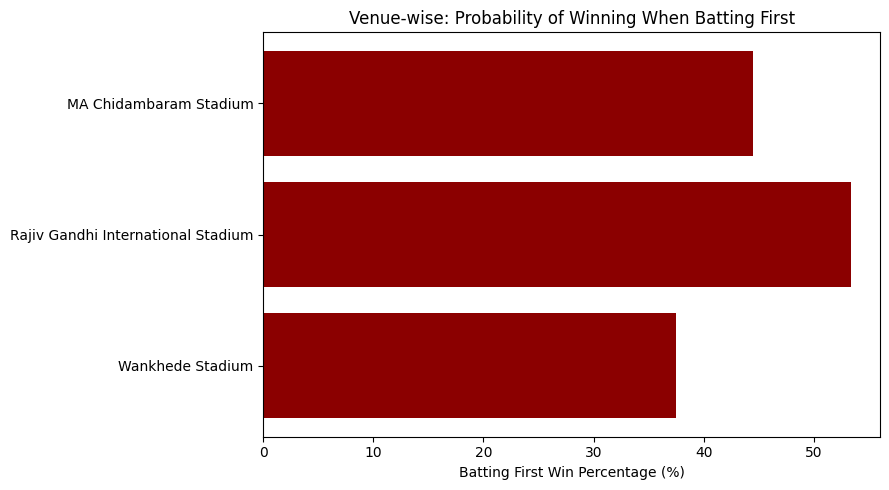

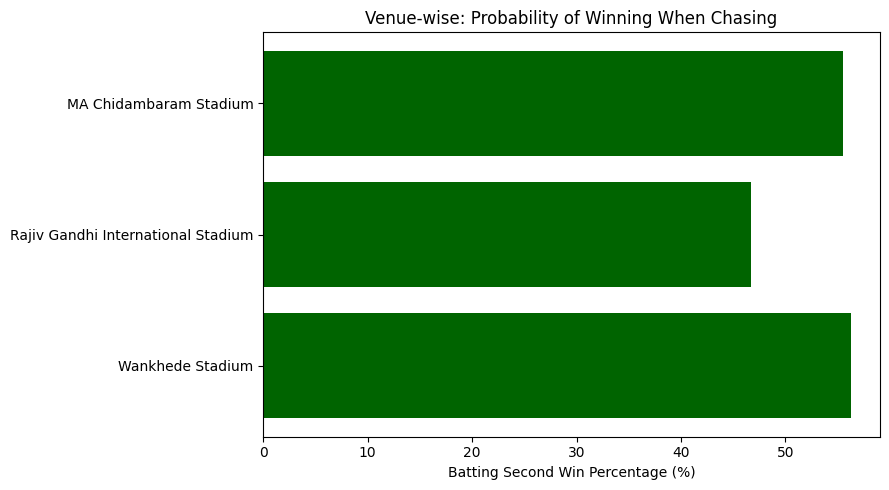

In [10]:
# ---------- VENUE-WISE BAT FIRST VS SECOND WIN PERCENTAGE ----------
import numpy as np
# ✅ Ensure batting first & second teams exist
matches_df['batting_first_team'] = np.where(matches_df['toss_decision'] == 'bat',
                                            matches_df['toss_winner'],
                                            matches_df.apply(lambda x: x['away_team'] if x['toss_winner']==x['home_team'] else x['home_team'], axis=1))
matches_df['batting_second_team'] = np.where(matches_df['batting_first_team'] == matches_df['home_team'],
                                             matches_df['away_team'], matches_df['home_team'])

# ✅ Determine which side won (batting first or chasing)
matches_df['bat_first_win'] = (matches_df['winner'] == matches_df['batting_first_team']).astype(int)
matches_df['bat_second_win'] = (matches_df['winner'] == matches_df['batting_second_team']).astype(int)

# ✅ Aggregate by venue
venue_bat_stats = matches_df.groupby('venue').agg(
    total_matches=('match_id','count'),
    bat_first_wins=('bat_first_win','sum'),
    bat_second_wins=('bat_second_win','sum')
).reset_index()

venue_bat_stats['bat_first_win_pct'] = (venue_bat_stats['bat_first_wins'] / venue_bat_stats['total_matches']) * 100
venue_bat_stats['bat_second_win_pct'] = (venue_bat_stats['bat_second_wins'] / venue_bat_stats['total_matches']) * 100

# ✅ Filter for popular venues
popular_venues = ['Wankhede Stadium', 'MA Chidambaram Stadium', 'Rajiv Gandhi International Stadium', 'M Chinnaswamy Stadium']
venue_filtered = venue_bat_stats[venue_bat_stats['venue'].isin(popular_venues)]

# ✅ Plot: Batting First Win % at Popular Venues
plt.figure(figsize=(9,5))
plt.barh(venue_filtered['venue'], venue_filtered['bat_first_win_pct'], color='darkred')
plt.xlabel("Batting First Win Percentage (%)")
plt.title("Venue-wise: Probability of Winning When Batting First")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ✅ Plot: Chasing Win % at Popular Venues
plt.figure(figsize=(9,5))
plt.barh(venue_filtered['venue'], venue_filtered['bat_second_win_pct'], color='darkgreen')
plt.xlabel("Batting Second Win Percentage (%)")
plt.title("Venue-wise: Probability of Winning When Chasing")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


⚠️ No death bowlers with 20 overs, using 10 overs as fallback


C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\1113984182.py:120: UserWarning: Glyph 127951 (\N{CRICKET BAT AND BALL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\gauti\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127951 (\N{CRICKET BAT AND BALL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


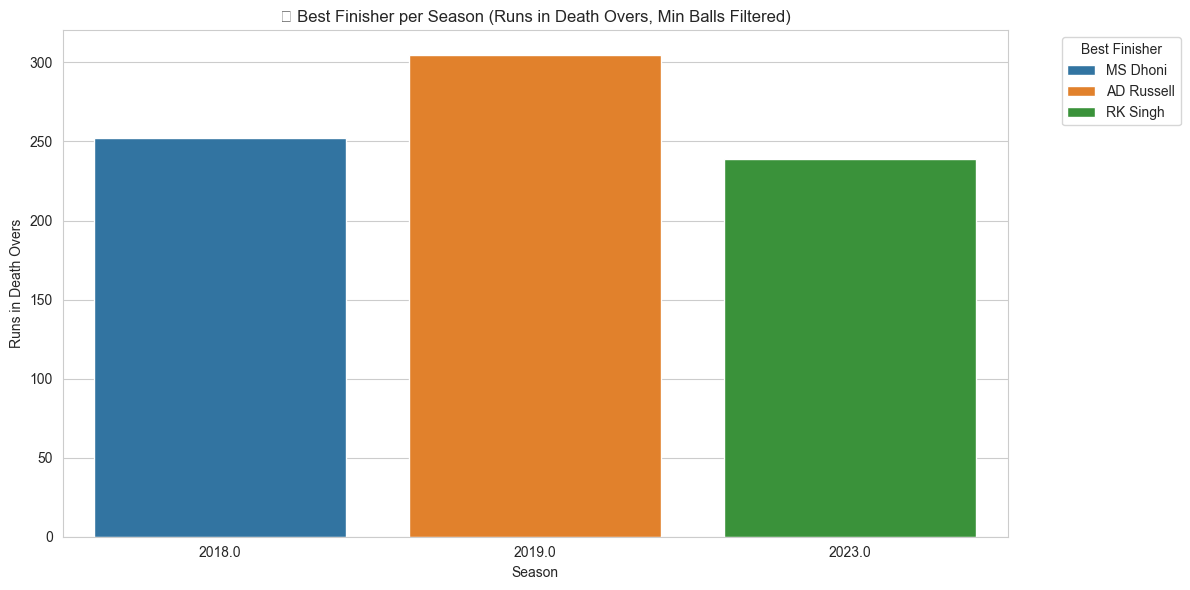

⚠️ No death bowlers found after filtering.


C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\1113984182.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=champion_counts, x="titles", y="team", palette="Set2")
C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\1113984182.py:146: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\gauti\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


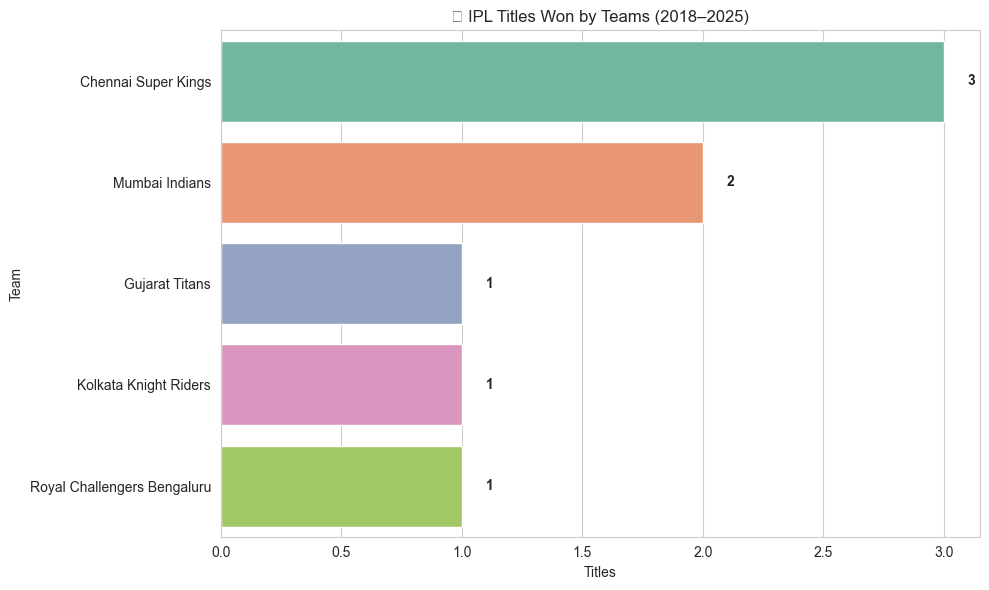

In [11]:
import os
import json
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ====================== STEP 1: Load and Extract Data ======================
zip_path = r"C:\Users\gauti\Downloads\ipl_json.zip"  # <- Your actual file
extract_path = r"C:\Users\gauti\Downloads\ipl_json_extracted"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

matches_data, deliveries_data = [], []
for file_name in os.listdir(extract_path):
    if not file_name.endswith(".json"):
        continue
    with open(os.path.join(extract_path, file_name)) as f:
        match_json = json.load(f)
    match_info = match_json.get("info", {})
    date = match_info.get("dates", [None])[0]
    if date is None or not (2018 <= int(date[:4]) <= 2025):
        continue
    match_id = file_name.replace(".json", "")
    matches_data.append({
        "match_id": match_id,
        "teams": match_info.get("teams", []),
        "venue": match_info.get("venue", ""),
        "city": match_info.get("city", ""),
        "date": date,
        "toss_winner": match_info.get("toss", {}).get("winner", ""),
        "toss_decision": match_info.get("toss", {}).get("decision", ""),
        "winner": match_info.get("outcome", {}).get("winner", None),
        "result": match_info.get("outcome", {}).get("result", None),
        "overs": match_info.get("overs", 20)
    })
    for inning in match_json.get("innings", []):
        team = inning.get("team", "")
        for over_data in inning.get("overs", []):
            over = over_data.get("over")
            for delivery in over_data.get("deliveries", []):
                deliveries_data.append({
                    "match_id": match_id,
                    "batting_team": team,
                    "over": over,
                    "batter": delivery.get("batter", ""),
                    "bowler": delivery.get("bowler", ""),
                    "runs_batter": delivery.get("runs", {}).get("batter", 0),
                    "runs_total": delivery.get("runs", {}).get("total", 0),
                    "wicket_type": delivery.get("wickets", [{}])[0].get("kind", None) if delivery.get("wickets") else None,
                    "player_out": delivery.get("wickets", [{}])[0].get("player_out", None) if delivery.get("wickets") else None
                })

matches_df = pd.DataFrame(matches_data)
deliveries_df = pd.DataFrame(deliveries_data)

# ====================== STEP 2: Cleaning ======================
matches_df['date'] = pd.to_datetime(matches_df['date'])
matches_df = matches_df[matches_df['result'].isnull() | (matches_df['result'] != 'no result')]
deliveries_df = deliveries_df.dropna(subset=['batter','bowler','batting_team'])
matches_df['season'] = matches_df['date'].dt.year
deliveries_df = deliveries_df.merge(matches_df[['match_id','season']], on='match_id', how='left')
wickets_df = deliveries_df[deliveries_df['wicket_type'].notna() & (deliveries_df['wicket_type'] != 'run out')]

# ====================== STEP 3: Filter Death Overs ======================
death_batting = deliveries_df[deliveries_df['over'] >= 16]
death_wickets = wickets_df[wickets_df['over'] >= 16]

# Function to filter and select best player
def get_best_player(df, group_cols, value_col, min_balls):
    balls_count = df.groupby(group_cols)[value_col].count().reset_index(name="balls")
    filtered = df.merge(balls_count, on=group_cols)
    filtered = filtered[filtered["balls"] >= min_balls]
    return filtered

# ====================== STEP 4: Best Finishers (≥120 balls or fallback) ======================
finishers_df = get_best_player(death_batting, ["season","batter"], "runs_batter", 120)
if finishers_df.empty:
    print("⚠️ No finishers with 120+ balls, using 60 balls as fallback")
    finishers_df = get_best_player(death_batting, ["season","batter"], "runs_batter", 60)

death_finishers = (finishers_df.groupby(["season","batter"])["runs_batter"].sum()
                   .reset_index().sort_values(["season","runs_batter"],ascending=[True,False])
                   .groupby("season").first().reset_index()
                   .rename(columns={"batter":"best_finisher","runs_batter":"death_runs"}))

overall_finish = (death_batting.groupby("batter")["runs_batter"].sum().reset_index()
                  .rename(columns={"runs_batter":"total_runs"}))

# ====================== STEP 5: Best Death Bowlers (≥120 balls or fallback) ======================
bowlers_df = get_best_player(death_wickets, ["season","bowler"], "player_out", 120)
if bowlers_df.empty:
    print("⚠️ No death bowlers with 20 overs, using 10 overs as fallback")
    bowlers_df = get_best_player(death_wickets, ["season","bowler"], "player_out", 60)

death_bowlers = (bowlers_df.groupby(["season","bowler"])["player_out"].count()
                 .reset_index().sort_values(["season","player_out"],ascending=[True,False])
                 .groupby("season").first().reset_index()
                 .rename(columns={"bowler":"best_death_bowler","player_out":"death_wickets"}))

overall_bowl = (death_wickets.groupby("bowler")["player_out"].count().reset_index()
                .rename(columns={"player_out":"total_wickets"}))

# ====================== STEP 6: Champion Teams ======================
final_matches = matches_df.sort_values("date").groupby("season").last().reset_index()
champion_counts = final_matches["winner"].value_counts().reset_index()
champion_counts.columns = ["team","titles"]

# ====================== STEP 7: Visualizations ======================
sns.set_style("whitegrid")

# --- Best Finisher Chart ---
if not death_finishers.empty:
    plt.figure(figsize=(12,6))
    sns.barplot(data=death_finishers, x="season", y="death_runs", hue="best_finisher", dodge=False)
    plt.title("🏏 Best Finisher per Season (Runs in Death Overs, Min Balls Filtered)")
    plt.ylabel("Runs in Death Overs")
    plt.xlabel("Season")
    plt.legend(title="Best Finisher", bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No best finishers found after filtering.")

# --- Best Death Bowler Chart ---
if not death_bowlers.empty:
    plt.figure(figsize=(12,6))
    sns.barplot(data=death_bowlers, x="season", y="death_wickets", hue="best_death_bowler", dodge=False, palette="coolwarm")
    plt.title("🎯 Best Death-Over Bowler per Season (Wickets, Min Overs Filtered)")
    plt.ylabel("Wickets in Death Overs")
    plt.xlabel("Season")
    plt.legend(title="Best Death Bowler", bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No death bowlers found after filtering.")

# --- Champion Teams Chart with Title Numbers ---
plt.figure(figsize=(10,6))
ax = sns.barplot(data=champion_counts, x="titles", y="team", palette="Set2")
plt.title("🏆 IPL Titles Won by Teams (2018–2025)")
plt.xlabel("Titles")
plt.ylabel("Team")
for index, row in champion_counts.iterrows():
    ax.text(row["titles"]+0.1, index, f"{row['titles']}", va="center", ha="left", fontsize=10, fontweight="bold")
plt.tight_layout()
plt.show()


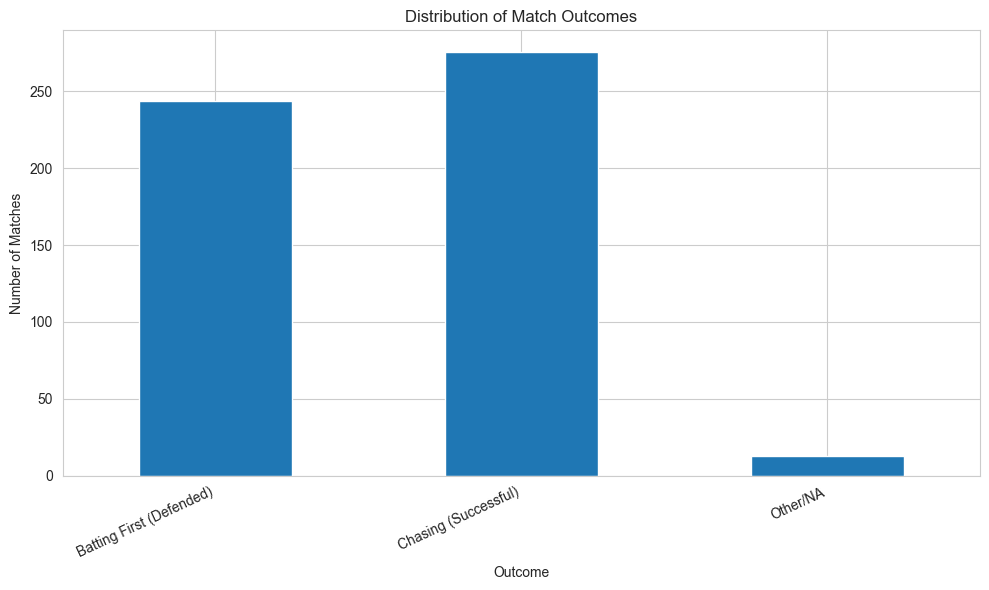

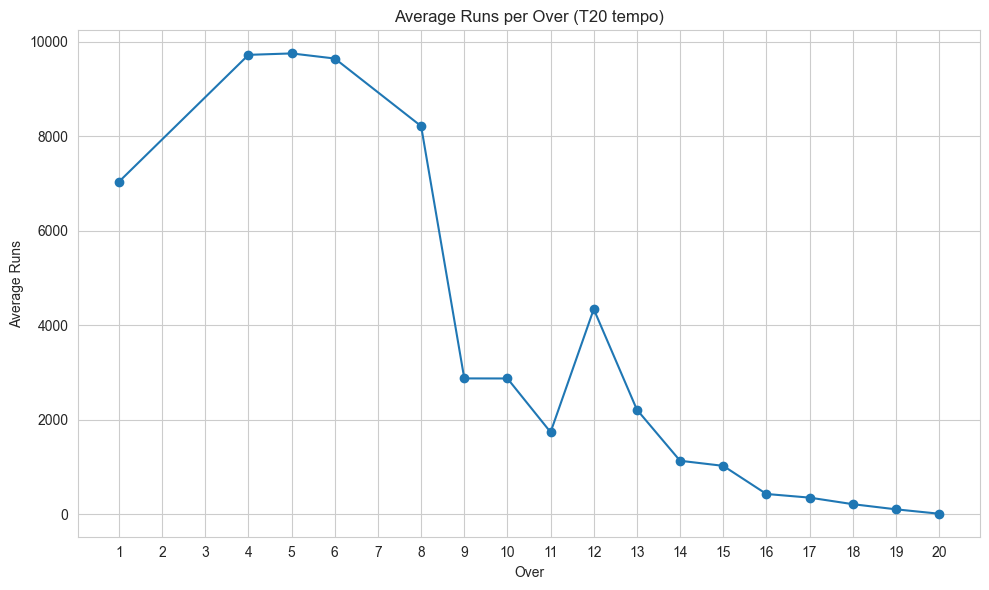

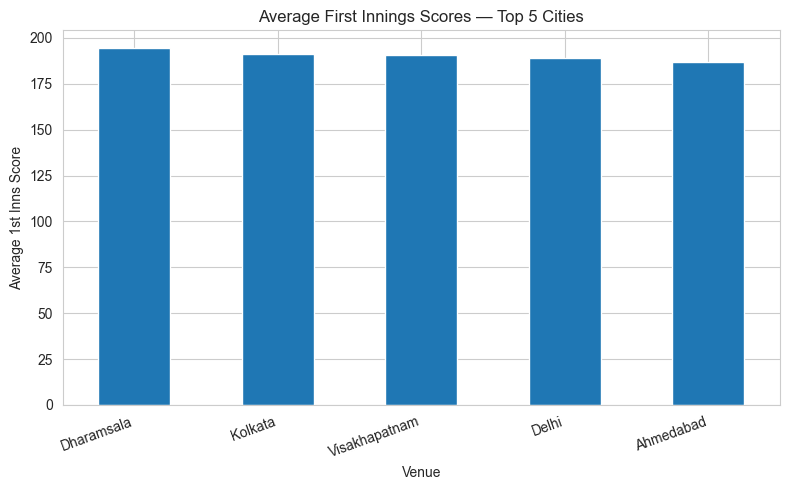

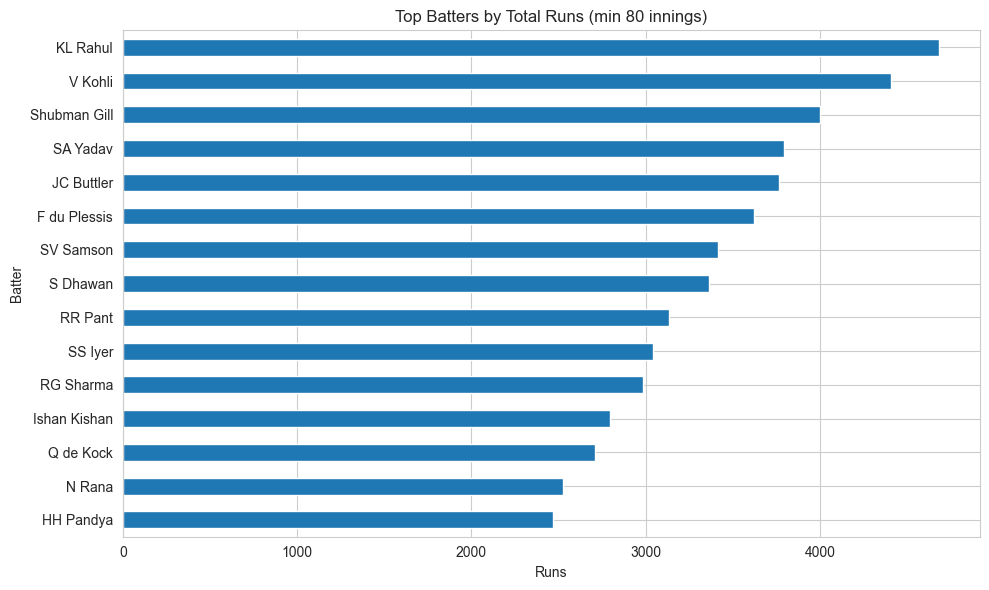

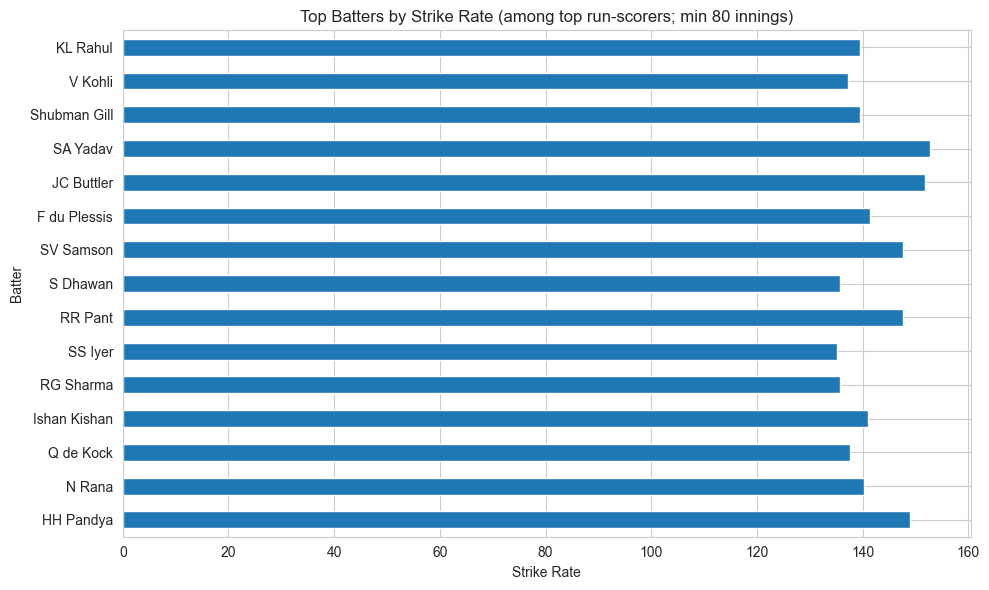

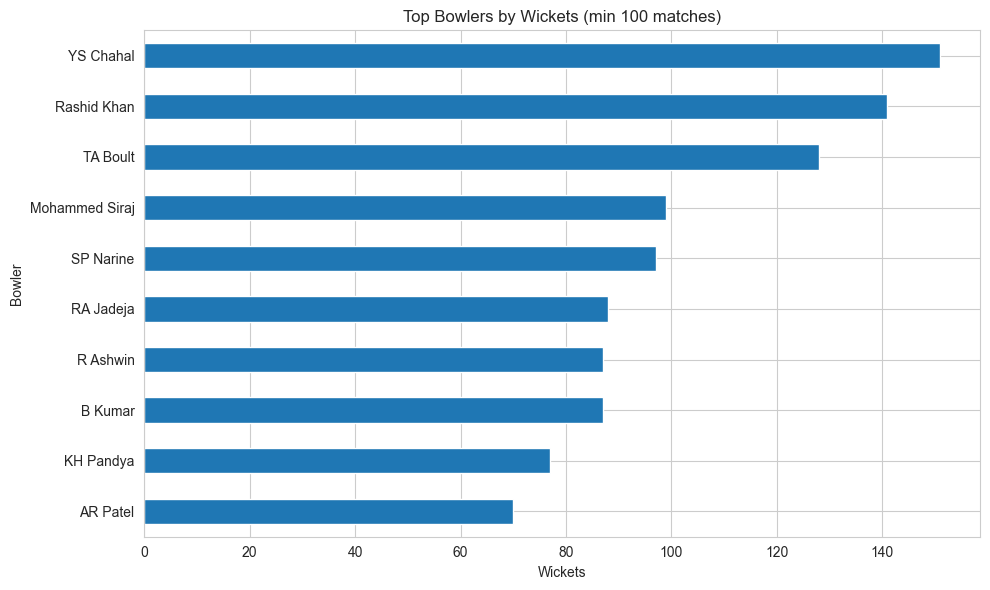

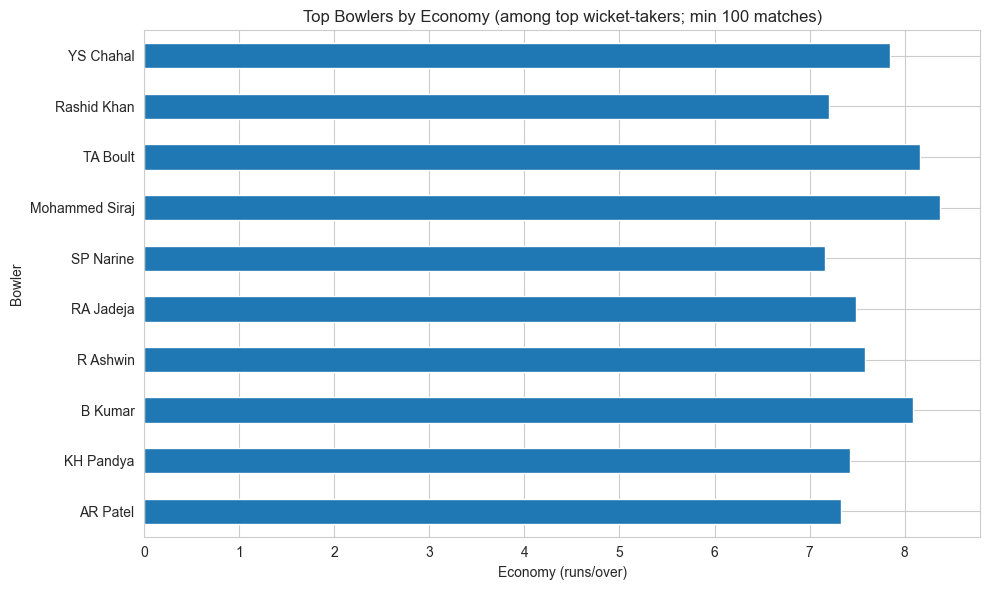

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load
matches = pd.read_csv("matches_2018_2025.csv")
deliveries = pd.read_csv("deliveries_2018_2025.csv")
matches.columns = [c.strip().lower().replace(" ", "_") for c in matches.columns]
deliveries.columns = [c.strip().lower().replace(" ", "_") for c in deliveries.columns]

# Column map for your schema
MID, OVER_COL, VENUE_COL, WINNER_COL = "match_id", "over", "venue", "winner"
BATTER_COL, BOWLER_COL = "batter", "bowler"
RUNS_TOTAL, RUNS_BATTER, RUNS_EXTRAS = "runs_total", "runs_batter", "runs_extras"
DISMISSAL_KIND, PLAYER_DISMISSED = "wicket_type", "player_out"

# Precompute totals
deliveries["_total_runs"] = deliveries[RUNS_TOTAL].fillna(0)

# 1) Distribution of Match Outcomes (bat first vs chase) — infer via toss
if {"toss_winner","toss_decision","winner"}.issubset(matches.columns):
    m = matches[[MID,"toss_winner","toss_decision","winner"]].copy()
    def outcome(r):
        if pd.isna(r["winner"]) or pd.isna(r["toss_decision"]): return "Other/NA"
        td = str(r["toss_decision"]).lower()
        same = (r["toss_winner"] == r["winner"])
        if td == "bat":   return "Batting First (Defended)" if same else "Chasing (Successful)"
        if td in ("field","bowl"): return "Chasing (Successful)" if same else "Batting First (Defended)"
        return "Other/NA"
    m["Outcome"] = m.apply(outcome, axis=1)
    oc = m["Outcome"].value_counts().reindex(["Batting First (Defended)","Chasing (Successful)","Other/NA"]).fillna(0)
else:
    oc = matches[WINNER_COL].value_counts().head(10)

plt.figure(figsize=(10,6))
oc.plot(kind="bar"); plt.title("Distribution of Match Outcomes")
plt.xlabel("Outcome"); plt.ylabel("Number of Matches")
plt.xticks(rotation=25, ha="right"); plt.tight_layout(); plt.show()

# 2) Average Runs per Over (T20 tempo) — your over is 0..19 so +1 for display
over_totals = deliveries.groupby(OVER_COL)["_total_runs"].sum().sort_index()
if "batting_team" in deliveries.columns:
    reached = deliveries.groupby([MID,"batting_team"])[OVER_COL].max().reset_index()
    innings_count = reached.groupby(OVER_COL)[OVER_COL].count()
    avg_runs = (over_totals / innings_count).dropna()
else:
    avg_runs = deliveries.groupby(OVER_COL)["_total_runs"].mean()
avg_runs.index = avg_runs.index.astype(int) + 1

plt.figure(figsize=(10,6))
plt.plot(avg_runs.index, avg_runs.values, marker="o")
plt.title("Average Runs per Over (T20 tempo)")
plt.xlabel("Over"); plt.ylabel("Average Runs")
plt.xticks(range(1, int(avg_runs.index.max())+1))
plt.tight_layout(); plt.show()

# 3) Venue-Based Average First Innings Scores (Top 20)
# Fix venue labels: use the 'city' column from matches for meaningful names.
import pandas as pd
import matplotlib.pyplot as plt

matches = pd.read_csv("matches_2018_2025.csv")
deliveries = pd.read_csv("deliveries_2018_2025.csv")
matches.columns = [c.strip().lower().replace(" ", "_") for c in matches.columns]
deliveries.columns = [c.strip().lower().replace(" ", "_") for c in deliveries.columns]

MID, OVER_COL = "match_id", "over"
RUNS_TOTAL = "runs_total"

deliveries["_total_runs"] = deliveries[RUNS_TOTAL].fillna(0)

# Compute average first-innings totals by CITY (not long venue name), show Top 5
if {"batting_team","city","venue","match_id"}.issubset(matches.columns.union(deliveries.columns)):
    # First batting team per match
    first_seen = (deliveries
                  .sort_values([MID, OVER_COL])
                  .groupby([MID,"batting_team"], as_index=False).head(1))
    first_team = first_seen.groupby(MID)["batting_team"].first().reset_index()
    inns1 = deliveries.merge(first_team, on=[MID,"batting_team"], how="inner")
    inns1_totals = inns1.groupby(MID)["_total_runs"].sum().reset_index(name="first_innings_total")

    # Map to city
    vmap = matches[[MID, "venue", "city"]].drop_duplicates()
    df = inns1_totals.merge(vmap, on=MID, how="left")

    # Prefer city for label; if city missing, fall back to a short venue token
    def short_label(row):
        city = row.get("city")
        if isinstance(city, str) and city.strip():
            return city
        venue = row.get("venue", "")
        if isinstance(venue, str) and "," in venue:
            return venue.split(",")[-1].strip()
        return venue.split()[0] if isinstance(venue, str) and venue else "Unknown"

    df["label"] = df.apply(short_label, axis=1)
    city_avg = df.groupby("label")["first_innings_total"].mean().sort_values(ascending=False).head(5)

    plt.figure(figsize=(8,5))
    city_avg.plot(kind="bar")
    plt.title("Average First Innings Scores — Top 5 Cities")
    plt.xlabel("Venue"); plt.ylabel("Average 1st Inns Score")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout(); plt.show()


# 4) Top Batters (total runs / strike rate) — fairness min innings, auto-relax if needed
MIN_BATTER_INN = 100
balls = deliveries.groupby(BATTER_COL).size().rename("balls")
runs = deliveries.groupby(BATTER_COL)["_total_runs"].sum().rename("runs")
if "batting_team" in deliveries.columns:
    inns = deliveries.groupby([BATTER_COL, MID, "batting_team"]).size().groupby(BATTER_COL).size().rename("innings_batted")
else:
    inns = deliveries.groupby([BATTER_COL, MID]).size().groupby(BATTER_COL).size().rename("innings_batted")

bat = pd.concat([inns, runs, balls], axis=1).fillna(0)
bat["strike_rate"] = np.where(bat["balls"]>0, 100*bat["runs"]/bat["balls"], np.nan)

thr = MIN_BATTER_INN
filt_bat = bat[bat["innings_batted"] >= thr]
while len(filt_bat) < 10 and thr > 10:
    thr = max(10, int(thr*0.8))
    filt_bat = bat[bat["innings_batted"] >= thr]

top_bat = filt_bat.sort_values(["runs","strike_rate"], ascending=[False, False]).head(15)

plt.figure(figsize=(10,6))
top_bat["runs"].iloc[::-1].plot(kind="barh")
plt.title(f"Top Batters by Total Runs (min {thr} innings)")
plt.xlabel("Runs"); plt.ylabel("Batter"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,6))
top_bat["strike_rate"].iloc[::-1].plot(kind="barh")
plt.title(f"Top Batters by Strike Rate (among top run-scorers; min {thr} innings)")
plt.xlabel("Strike Rate"); plt.ylabel("Batter"); plt.tight_layout(); plt.show()

# 5) Top Bowlers (wickets / economy) — fairness min matches, auto-relax if needed
MIN_BOWLER_MATCHES = 100
balls_bowled = deliveries.groupby(BOWLER_COL).size().rename("balls")
overs = balls_bowled / 6.0
runs_conc = deliveries.groupby(BOWLER_COL)["_total_runs"].sum().rename("runs_conceded")

def credited(kind):
    if not isinstance(kind, str): return False
    k = kind.lower()
    return k in {"bowled","caught","lbw","stumped","caught and bowled","hit wicket"}
wk = deliveries[deliveries[PLAYER_DISMISSED].notna()].copy()
wk["credit"] = wk[DISMISSAL_KIND].map(credited)
wickets = wk[wk["credit"]].groupby(BOWLER_COL).size().rename("wickets")

mb = deliveries.groupby([BOWLER_COL, MID]).size().groupby(BOWLER_COL).size().rename("matches_bowled")

bw = pd.concat([mb, balls_bowled, overs.rename("overs"), runs_conc, wickets], axis=1).fillna(0)
bw["economy"] = np.where(bw["overs"]>0, bw["runs_conceded"]/bw["overs"], np.nan)

thrb = MIN_BOWLER_MATCHES
filt_bw = bw[bw["matches_bowled"] >= thrb]
while len(filt_bw) < 10 and thrb > 10:
    thrb = max(10, int(thrb*0.8))
    filt_bw = bw[bw["matches_bowled"] >= thrb]

top_bw = filt_bw.sort_values(["wickets","economy"], ascending=[False, True]).head(15)

plt.figure(figsize=(10,6))
top_bw["wickets"].iloc[::-1].plot(kind="barh")
plt.title(f"Top Bowlers by Wickets (min {thrb} matches)")
plt.xlabel("Wickets"); plt.ylabel("Bowler"); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,6))
top_bw["economy"].iloc[::-1].plot(kind="barh")
plt.title(f"Top Bowlers by Economy (among top wicket-takers; min {thrb} matches)")
plt.xlabel("Economy (runs/over)"); plt.ylabel("Bowler"); plt.tight_layout(); plt.show()


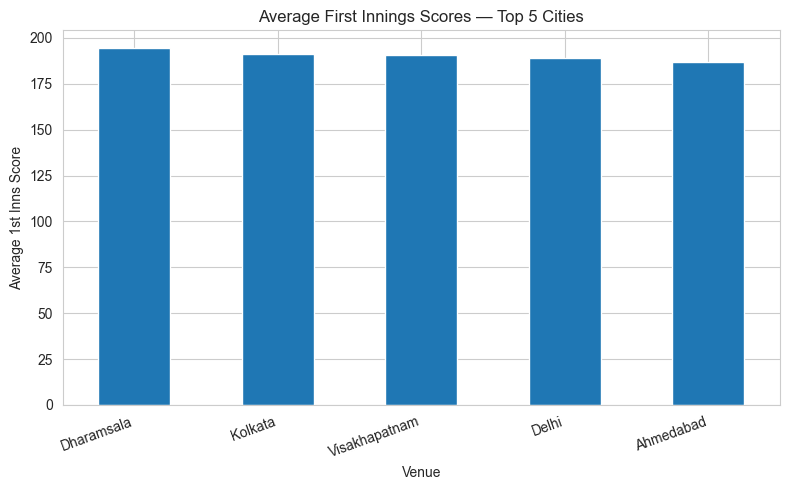

In [26]:
# Fix venue labels: use the 'city' column from matches for meaningful names.
import pandas as pd
import matplotlib.pyplot as plt

matches = pd.read_csv("matches_2018_2025.csv")
deliveries = pd.read_csv("deliveries_2018_2025.csv")
matches.columns = [c.strip().lower().replace(" ", "_") for c in matches.columns]
deliveries.columns = [c.strip().lower().replace(" ", "_") for c in deliveries.columns]

MID, OVER_COL = "match_id", "over"
RUNS_TOTAL = "runs_total"

deliveries["_total_runs"] = deliveries[RUNS_TOTAL].fillna(0)

# Compute average first-innings totals by CITY (not long venue name), show Top 5
if {"batting_team","city","venue","match_id"}.issubset(matches.columns.union(deliveries.columns)):
    # First batting team per match
    first_seen = (deliveries
                  .sort_values([MID, OVER_COL])
                  .groupby([MID,"batting_team"], as_index=False).head(1))
    first_team = first_seen.groupby(MID)["batting_team"].first().reset_index()
    inns1 = deliveries.merge(first_team, on=[MID,"batting_team"], how="inner")
    inns1_totals = inns1.groupby(MID)["_total_runs"].sum().reset_index(name="first_innings_total")

    # Map to city
    vmap = matches[[MID, "venue", "city"]].drop_duplicates()
    df = inns1_totals.merge(vmap, on=MID, how="left")

    # Prefer city for label; if city missing, fall back to a short venue token
    def short_label(row):
        city = row.get("city")
        if isinstance(city, str) and city.strip():
            return city
        venue = row.get("venue", "")
        if isinstance(venue, str) and "," in venue:
            return venue.split(",")[-1].strip()
        return venue.split()[0] if isinstance(venue, str) and venue else "Unknown"

    df["label"] = df.apply(short_label, axis=1)
    city_avg = df.groupby("label")["first_innings_total"].mean().sort_values(ascending=False).head(5)

    plt.figure(figsize=(8,5))
    city_avg.plot(kind="bar")
    plt.title("Average First Innings Scores — Top 5 Cities")
    plt.xlabel("Venue"); plt.ylabel("Average 1st Inns Score")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout(); plt.show()


### Feature Engineering - For Prediction,  Analysis & Dashboard, Insight Generation

In [13]:
import pandas as pd
import numpy as np

# ✅ Load parsed data
df_matches = matches_df.copy()
df_deliveries = deliveries_df.copy()

# ================== 0) IDs & Season (robust) ==================
# Ensure string match_ids
for df in (df_matches, df_deliveries):
    if 'match_id' not in df.columns:
        raise KeyError("match_id column is required in both matches_df and deliveries_df")
    df['match_id'] = df['match_id'].astype(str)

# Ensure 'season' in df_matches
if 'season' not in df_matches.columns:
    df_matches['season'] = df_matches['match_id'].str[:4]
df_matches['season'] = df_matches['season'].astype(str).fillna('unknown')

# Merge season into deliveries safely
df_deliveries = df_deliveries.merge(
    df_matches[['match_id', 'season']].rename(columns={'season': 'season_from_matches'}),
    on='match_id',
    how='left'
)

# Consolidate to a single 'season' in df_deliveries with fallback
if 'season' in df_deliveries.columns:
    df_deliveries['season'] = df_deliveries['season'].fillna(df_deliveries['season_from_matches'])
else:
    df_deliveries['season'] = df_deliveries['season_from_matches']
if 'season_from_matches' in df_deliveries.columns:
    df_deliveries.drop(columns=['season_from_matches'], inplace=True)

# Final fallback from match_id slice and enforce string dtype
df_deliveries['season'] = df_deliveries['season'].fillna(df_deliveries['match_id'].str[:4])
df_deliveries['season'] = df_deliveries['season'].astype(str).fillna('unknown')

# ================== 1) Match Context ==================
df_matches['home_team'] = df_matches['teams'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
df_matches['away_team'] = df_matches['teams'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else np.nan)
df_matches['toss_won'] = (df_matches.get('toss_winner') == df_matches['home_team']).astype(int)
df_matches['bat_first'] = (df_matches.get('toss_decision') == 'bat').astype(int)

# ================== 2) Run Rate Features ==================
if 'runs_total' not in df_deliveries.columns:
    raise KeyError("Expected 'runs_total' in deliveries.")
if 'over' not in df_deliveries.columns:
    raise KeyError("Expected 'over' in deliveries.")

match_runs = df_deliveries.groupby('match_id')['runs_total'].sum().reset_index(name='total_runs')
match_overs = df_deliveries.groupby('match_id')['over'].max().reset_index(name='overs')
match_rr = match_runs.merge(match_overs, on='match_id', how='left')
match_rr['run_rate'] = match_rr['total_runs'] / (match_rr['overs'] + 1e-6)
df_matches = df_matches.merge(match_rr[['match_id', 'run_rate']], on='match_id', how='left')

def phase_run_rate(df, start, end, col):
    phase = df[(df['over'] >= start) & (df['over'] <= end)]
    runs = phase.groupby('match_id')['runs_total'].sum()
    return runs.reset_index().rename(columns={'runs_total': col})

df_matches = df_matches.merge(phase_run_rate(df_deliveries, 1, 6, 'powerplay_runs'), on='match_id', how='left')
df_matches = df_matches.merge(phase_run_rate(df_deliveries, 16, 20, 'death_runs'), on='match_id', how='left')
df_matches['pp_run_rate'] = df_matches['powerplay_runs'] / 6
df_matches['death_run_rate'] = df_matches['death_runs'] / 5
df_matches['pp_aggression'] = df_matches['pp_run_rate'] / (df_matches['run_rate'] + 1e-6)
df_matches['death_efficiency'] = df_matches['death_run_rate'] / (df_matches['run_rate'] + 1e-6)

# ================== 3) Partnerships ==================
if 'batting_team' not in df_deliveries.columns:
    raise KeyError("Expected 'batting_team' in deliveries.")
team_partners = df_deliveries.groupby(['match_id', 'batting_team'])['runs_total'].sum().reset_index()
team_partners = team_partners.groupby('match_id')['runs_total'].mean().reset_index(name='avg_partnership')
df_matches = df_matches.merge(team_partners, on='match_id', how='left')

# ================== 4) Team Historical Stats ==================
# Align dtypes for merge keys
df_matches['season'] = df_matches['season'].astype(str)
df_deliveries['season'] = df_deliveries['season'].astype(str)

team_runs = df_deliveries.groupby(['season', 'batting_team', 'match_id'])['runs_total'].sum().reset_index()
team_runs['season'] = team_runs['season'].astype(str)  # ensure string
team_strength = team_runs.groupby(['season', 'batting_team'])['runs_total'].mean().reset_index(name='team_avg_runs')
team_strength['season'] = team_strength['season'].astype(str)

for team_col, avg_col in [('home_team', 'home_avg_runs'), ('away_team', 'away_avg_runs')]:
    rhs = team_strength.rename(columns={'batting_team': team_col, 'team_avg_runs': avg_col})
    # ensure rhs key dtypes align with lhs (df_matches)
    rhs['season'] = rhs['season'].astype(str)
    # team_col may have NaNs in df_matches; merge will naturally skip those
    df_matches = df_matches.merge(rhs, on=['season', team_col], how='left')

df_matches['run_rate_diff'] = df_matches['home_avg_runs'] - df_matches['away_avg_runs']

# ================== 5) Death Over Bowling Strength ==================
if 'wicket_type' not in df_deliveries.columns:
    df_deliveries['wicket_type'] = np.nan
death_wickets = df_deliveries[(df_deliveries['over'] >= 16) & (df_deliveries['wicket_type'].notna())]

if 'player_out' not in df_deliveries.columns:
    team_death_wkts = death_wickets.groupby(['season', 'batting_team']).size().reset_index(name='avg_death_wkts')
else:
    team_death_wkts = death_wickets.groupby(['season', 'batting_team'])['player_out'].count().reset_index(name='avg_death_wkts')

team_death_wkts['season'] = team_death_wkts['season'].astype(str)

for team_col, death_col in [('home_team', 'home_death_wkts'), ('away_team', 'away_death_wkts')]:
    rhs = team_death_wkts.rename(columns={'batting_team': team_col, 'avg_death_wkts': death_col})
    rhs['season'] = rhs['season'].astype(str)
    df_matches = df_matches.merge(rhs, on=['season', team_col], how='left')

df_matches['death_diff'] = df_matches['home_death_wkts'] - df_matches['away_death_wkts']

# ================== 6) Venue Stats ==================
if 'venue' not in df_matches.columns:
    df_matches['venue'] = 'unknown'
venue_avg = df_matches.groupby('venue')['run_rate'].mean().reset_index(name='venue_avg_runrate')
venue_batfirst = df_matches.groupby('venue')['bat_first'].mean().reset_index(name='venue_batfirst_win_rate')
df_matches = df_matches.merge(venue_avg, on='venue', how='left').merge(venue_batfirst, on='venue', how='left')

# ================== 7) Player Form ==================
if 'is_wicket' not in df_deliveries.columns:
    df_deliveries['is_wicket'] = np.where(df_deliveries['wicket_type'].notna(), 1, 0)
if 'batter' not in df_deliveries.columns:
    df_deliveries['batter'] = 'unknown'
if 'bowler' not in df_deliveries.columns:
    df_deliveries['bowler'] = 'unknown'
if 'runs_batter' not in df_deliveries.columns:
    df_deliveries['runs_batter'] = 0

df_deliveries['batter_form'] = df_deliveries.groupby('batter')['runs_batter'].transform(lambda x: x.rolling(5, min_periods=1).mean())
df_deliveries['bowler_form'] = df_deliveries.groupby('bowler')['is_wicket'].transform(lambda x: x.rolling(5, min_periods=1).mean())
form = df_deliveries.groupby('match_id').agg({'batter_form': 'mean', 'bowler_form': 'mean'}).reset_index()
form.rename(columns={'batter_form': 'avg_batter_form', 'bowler_form': 'avg_bowler_form'}, inplace=True)
df_matches = df_matches.merge(form, on='match_id', how='left')

# ================== 8) Venue + Toss Interaction ==================
if 'toss_winner' not in df_matches.columns:
    df_matches['toss_winner'] = np.nan
if 'winner' not in df_matches.columns:
    df_matches['winner'] = np.nan
df_matches['venue_toss_adv'] = df_matches['venue'].astype(str) + "_" + df_matches['toss_winner'].astype(str)

def _toss_rate(group):
    key = group.name
    if isinstance(key, str) and "_" in key:
        toss_winner = key.split("_", 1)[1]
        return (group == toss_winner).mean()
    return np.nan

venue_toss_winrate = df_matches.groupby('venue_toss_adv')['winner'].apply(_toss_rate).reset_index(name='venue_toss_win_rate')
df_matches = df_matches.merge(venue_toss_winrate, on='venue_toss_adv', how='left')

# ================== 9) Head-to-Head ==================
df_matches['win_flag'] = np.where(df_matches['winner'] == df_matches['home_team'], 1, 0)
h2h = df_matches.groupby(['home_team', 'away_team'])['win_flag'].mean().reset_index(name='h2h_win_rate_home')
df_matches = df_matches.merge(h2h, on=['home_team', 'away_team'], how='left')

# ================== 10) Interaction Features ==================
df_matches['pp_venue_interaction'] = df_matches.get('pp_aggression', 0) * df_matches.get('venue_batfirst_win_rate', 0)
df_matches['death_interaction'] = df_matches.get('death_efficiency', 0) * df_matches.get('death_diff', 0)
df_matches['form_advantage'] = df_matches.get('avg_batter_form', 0) - df_matches.get('avg_bowler_form', 0)

# ================== 11) Final Columns ==================
feature_columns = [
    'match_id', 'season', 'home_team', 'away_team', 'run_rate', 'pp_run_rate', 'death_run_rate', 'pp_aggression',
    'death_efficiency', 'avg_partnership', 'home_avg_runs', 'away_avg_runs', 'run_rate_diff',
    'home_death_wkts', 'away_death_wkts', 'death_diff', 'venue_avg_runrate', 'venue_batfirst_win_rate',
    'h2h_win_rate_home', 'toss_won', 'bat_first', 'avg_batter_form', 'avg_bowler_form', 'venue_toss_win_rate',
    'pp_venue_interaction', 'death_interaction', 'form_advantage', 'win_flag'
]

feature_columns = [c for c in feature_columns if c in df_matches.columns]
match_features = df_matches[feature_columns].fillna(0)

# ================== 12) Save ==================
match_features.to_csv("match_features_dataset_v3.csv", index=False)
print("✅ Feature Engineering V3 Completed. Saved as match_features_dataset_v3.csv")
print("📌 Final Columns:", match_features.columns.tolist())


C:\Users\gauti\AppData\Local\Temp\ipykernel_1004\3957825040.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_deliveries['season'] = df_deliveries['season'].fillna(df_deliveries['season_from_matches'])


✅ Feature Engineering V3 Completed. Saved as match_features_dataset_v3.csv
📌 Final Columns: ['match_id', 'season', 'home_team', 'away_team', 'run_rate', 'pp_run_rate', 'death_run_rate', 'pp_aggression', 'death_efficiency', 'avg_partnership', 'home_avg_runs', 'away_avg_runs', 'run_rate_diff', 'home_death_wkts', 'away_death_wkts', 'death_diff', 'venue_avg_runrate', 'venue_batfirst_win_rate', 'h2h_win_rate_home', 'toss_won', 'bat_first', 'avg_batter_form', 'avg_bowler_form', 'venue_toss_win_rate', 'pp_venue_interaction', 'death_interaction', 'form_advantage', 'win_flag']


## Predictive Modelling

[I 2025-08-20 13:22:06,926] A new study created in memory with name: no-name-82e84e0e-2fe0-484e-827f-f13e44ce780b



✅ Valid Team Names: ['Chennai Super Kings', 'Delhi Capitals', 'Delhi Daredevils', 'Gujarat Titans', 'Kings XI Punjab', 'Kolkata Knight Riders', 'Lucknow Super Giants', 'Mumbai Indians', 'Punjab Kings', 'Rajasthan Royals', 'Royal Challengers Bangalore', 'Royal Challengers Bengaluru', 'Sunrisers Hyderabad']
🔎 Tuning Random Forest...


[I 2025-08-20 13:22:13,621] Trial 0 finished with value: 0.7777777777777778 and parameters: {'n_estimators': 604, 'max_depth': 15, 'min_samples_split': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.7777777777777778.
[I 2025-08-20 13:22:23,821] Trial 1 finished with value: 0.7750677506775068 and parameters: {'n_estimators': 790, 'max_depth': 11, 'min_samples_split': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.7777777777777778.
[I 2025-08-20 13:22:28,846] Trial 2 finished with value: 0.7533875338753386 and parameters: {'n_estimators': 421, 'max_depth': 6, 'min_samples_split': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.7777777777777778.
[I 2025-08-20 13:22:38,399] Trial 3 finished with value: 0.7669376693766937 and parameters: {'n_estimators': 754, 'max_depth': 7, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7777777777777778.
[I 2025-08-20 13:22:47,522] Trial 4 finished with value: 0.7642276422764228 and parameter

🔎 Tuning XGBoost...


[I 2025-08-20 13:24:21,840] Trial 0 finished with value: 0.7560975609756097 and parameters: {'n_estimators': 712, 'max_depth': 6, 'learning_rate': 0.05648011488290539, 'subsample': 0.9694069700006644, 'colsample_bytree': 0.7675855237367821}. Best is trial 0 with value: 0.7560975609756097.
[I 2025-08-20 13:24:28,052] Trial 1 finished with value: 0.7669376693766937 and parameters: {'n_estimators': 885, 'max_depth': 7, 'learning_rate': 0.10898668646859, 'subsample': 0.7132779235901916, 'colsample_bytree': 0.8691910641288823}. Best is trial 1 with value: 0.7669376693766937.
[I 2025-08-20 13:24:35,962] Trial 2 finished with value: 0.7642276422764227 and parameters: {'n_estimators': 760, 'max_depth': 10, 'learning_rate': 0.040458546970487654, 'subsample': 0.9133076214901027, 'colsample_bytree': 0.8782682564315502}. Best is trial 1 with value: 0.7669376693766937.
[I 2025-08-20 13:24:41,028] Trial 3 finished with value: 0.7560975609756097 and parameters: {'n_estimators': 716, 'max_depth': 4, '

[LightGBM] [Info] Number of positive: 171, number of negative: 198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1205
[LightGBM] [Info] Number of data points in the train set: 369, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463415 -> initscore=-0.146603
[LightGBM] [Info] Start training from score -0.146603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-08-20 13:27:04,645] A new study created in memory with name: no-name-4020475f-873c-4075-96fc-207d1520f5ed
[I 2025-08-20 13:27:04,654] Trial 0 finished with value: 0.8238993710691824 and parameters: {'w_cat': 0.7352915503288364}. Best is trial 0 with value: 0.8238993710691824.
[I 2025-08-20 13:27:04,659] Trial 1 finished with value: 0.8050314465408805 and parameters: {'w_cat': 0.11801242898731124}. Best is trial 0 with value: 0.8238993710691824.
[I 2025-08-20 13:27:04,662] Trial 2 finished with value: 0.8050314465408805 and parameters: {'w_cat': 0.3383550909997335}. Best is trial 0 with value: 0.8238993710691824.
[I 2025-08-20 13:27:04,664] Trial 3 finished with value: 0.8176100628930818 and parameters: {'w_cat': 0.5991506532811104}. Best is trial 0 with value: 0.8238993710691824.
[I 2025-08-20 13:27:04,667] Trial 4 finished with value: 0.8176100628930818 and parameters: {'w_cat': 0.6702465037372569}. Best is trial 0 with value: 0.8238993710691824.
[I 2025-08-20 13:27:04,672] Tr

🔎 Optimizing Blending Weights...


[I 2025-08-20 13:27:04,858] Trial 21 finished with value: 0.8301886792452831 and parameters: {'w_cat': 0.5216976667599602}. Best is trial 13 with value: 0.8301886792452831.
[I 2025-08-20 13:27:04,873] Trial 22 finished with value: 0.8238993710691824 and parameters: {'w_cat': 0.43644894382017807}. Best is trial 13 with value: 0.8301886792452831.
[I 2025-08-20 13:27:04,886] Trial 23 finished with value: 0.8301886792452831 and parameters: {'w_cat': 0.5140347033309216}. Best is trial 13 with value: 0.8301886792452831.
[I 2025-08-20 13:27:04,900] Trial 24 finished with value: 0.8176100628930818 and parameters: {'w_cat': 0.6493942107573565}. Best is trial 13 with value: 0.8301886792452831.
[I 2025-08-20 13:27:04,910] Trial 25 finished with value: 0.8050314465408805 and parameters: {'w_cat': 0.3178938864337627}. Best is trial 13 with value: 0.8301886792452831.
[I 2025-08-20 13:27:04,925] Trial 26 finished with value: 0.8238993710691824 and parameters: {'w_cat': 0.4870051361747412}. Best is tr

✅ Optimal Weights: CatBoost=0.54, Stacking=0.46

🎯 FINAL OPTIMIZED BLENDED MODEL PERFORMANCE:
Accuracy: 0.8302
ROC-AUC:  0.9059

📌 Plotting SHAP Feature Importance...


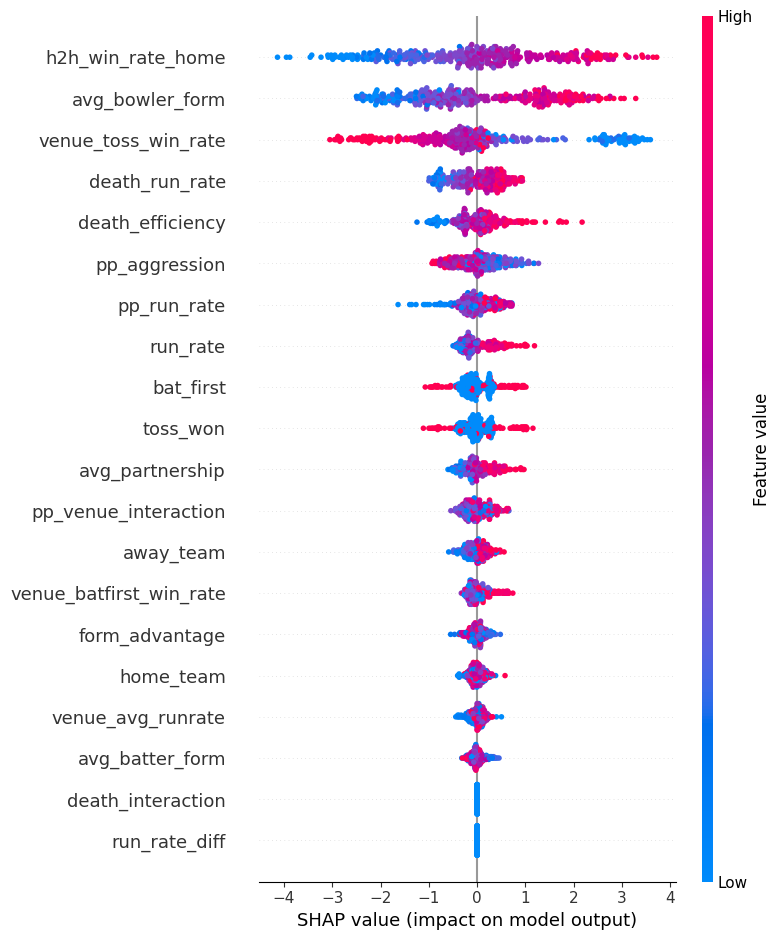


🔮 Example Prediction: 0.10797287328404656

📊 Random Forest Performance:
   Accuracy: 0.7736
   Recall:   0.7808
   F1-score: 0.7600
   ROC-AUC:  0.8950

📊 XGBoost Performance:
   Accuracy: 0.7547
   Recall:   0.7534
   F1-score: 0.7383
   ROC-AUC:  0.8721

📊 LightGBM Performance:
   Accuracy: 0.7925
   Recall:   0.7808
   F1-score: 0.7755
   ROC-AUC:  0.8718

📊 CatBoost Performance:
   Accuracy: 0.8239
   Recall:   0.8219
   F1-score: 0.8108
   ROC-AUC:  0.9040

📊 GradientBoosting Performance:
   Accuracy: 0.8176
   Recall:   0.8082
   F1-score: 0.8027
   ROC-AUC:  0.8926

📊 Stacking Ensemble Performance:
   Accuracy: 0.8050
   Recall:   0.7808
   F1-score: 0.7862
   ROC-AUC:  0.9060

🎯 Blended Model Performance (Optimized Weights):
   Accuracy: 0.8302
   Recall:   0.8082
   F1-score: 0.8138
   ROC-AUC:  0.9059


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import optuna
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ================== STEP 1: Load Dataset ==================
df = pd.read_csv("match_features_dataset_v3.csv")

# ✅ Select features
feature_candidates = [
    "run_rate","pp_run_rate","death_run_rate","pp_aggression","death_efficiency",
    "avg_partnership","home_avg_runs","away_avg_runs","run_rate_diff",
    "death_diff","venue_avg_runrate","venue_batfirst_win_rate","h2h_win_rate_home",
    "toss_won","bat_first","avg_batter_form","avg_bowler_form","venue_toss_win_rate",
    "pp_venue_interaction","death_interaction","form_advantage",
    "home_team","away_team","win_flag"
]
features = [f for f in feature_candidates if f in df.columns]
df = df[features]

# ================== STEP 2: Encode Teams ==================
le = LabelEncoder()
df["home_team"] = le.fit_transform(df["home_team"].astype(str))
df["away_team"] = le.fit_transform(df["away_team"].astype(str))

# ✅ List valid team names
valid_team_names = list(le.classes_)
print("\n✅ Valid Team Names:", valid_team_names)

# ================== STEP 3: Train-Test Split (70/30) ==================
X = df.drop(columns=["win_flag"])
y = df["win_flag"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# ================== STEP 4: Train Models ==================
# 🔹 Random Forest (Optuna tuned)
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 900),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }
    rf = RandomForestClassifier(**params, random_state=42)
    return cross_val_score(rf, X_train, y_train, cv=3, scoring="accuracy").mean()

print("🔎 Tuning Random Forest...")
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=15)
rf_params = study_rf.best_params
rf_best = RandomForestClassifier(**rf_params, random_state=42).fit(X_train, y_train)

# 🔹 XGBoost (Optuna tuned)
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 900),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0)
    }
    xgb_temp = XGBClassifier(**params, random_state=42, eval_metric="logloss", use_label_encoder=False)
    return cross_val_score(xgb_temp, X_train, y_train, cv=3, scoring="accuracy").mean()

print("🔎 Tuning XGBoost...")
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=15)
xgb_params = study_xgb.best_params
xgb_best = XGBClassifier(**xgb_params, random_state=42, eval_metric="logloss", use_label_encoder=False).fit(X_train, y_train)

# 🔹 Other Models
lgb = LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42).fit(X_train, y_train)
cat = CatBoostClassifier(iterations=500, depth=7, learning_rate=0.05, random_seed=42, verbose=0).fit(X_train, y_train)
gb = GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, max_depth=6, random_state=42).fit(X_train, y_train)

# 🔹 Stacking Ensemble
meta_lr = LogisticRegression(max_iter=3000)
stacking_model = StackingClassifier(
    estimators=[("rf", rf_best), ("xgb", xgb_best), ("lgb", lgb), ("cat", cat), ("gb", gb)],
    final_estimator=meta_lr,
    stack_method="predict_proba",
    cv=5,
    n_jobs=-1
).fit(X_train, y_train)

# ================== STEP 5: Blending Optimization with Optuna ==================
cat_probs = cat.predict_proba(X_test)[:,1]
stack_probs = stacking_model.predict_proba(X_test)[:,1]

def objective_blend(trial):
    w_cat = trial.suggest_float("w_cat", 0.0, 1.0)
    w_stack = 1.0 - w_cat
    blended = (w_cat * cat_probs) + (w_stack * stack_probs)
    preds = (blended > 0.5).astype(int)
    return accuracy_score(y_test, preds)

print("🔎 Optimizing Blending Weights...")
study_blend = optuna.create_study(direction="maximize")
study_blend.optimize(objective_blend, n_trials=50)

best_w_cat = study_blend.best_params["w_cat"]
best_w_stack = 1.0 - best_w_cat
print(f"✅ Optimal Weights: CatBoost={best_w_cat:.2f}, Stacking={best_w_stack:.2f}")

final_probs_opt = (best_w_cat * cat_probs) + (best_w_stack * stack_probs)
final_preds_opt = (final_probs_opt > 0.5).astype(int)
final_acc_opt = accuracy_score(y_test, final_preds_opt)
final_auc_opt = roc_auc_score(y_test, final_probs_opt)

print("\n🎯 FINAL OPTIMIZED BLENDED MODEL PERFORMANCE:")
print(f"Accuracy: {final_acc_opt:.4f}")
print(f"ROC-AUC:  {final_auc_opt:.4f}")

# ================== STEP 6: SHAP Feature Importance (CatBoost) ==================
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_train)
print("\n📌 Plotting SHAP Feature Importance...")
shap.summary_plot(shap_values, X_train, feature_names=df.drop(columns=["win_flag"]).columns)

# ================== STEP 7: Prediction API (Using Optimized Weights) ==================
team_name_map = {
    "CSK": "Chennai Super Kings",
    "MI": "Mumbai Indians",
    "RCB": "Royal Challengers Bangalore",
    "KKR": "Kolkata Knight Riders",
    "SRH": "Sunrisers Hyderabad",
    "RR": "Rajasthan Royals",
    "DC": "Delhi Capitals",
    "PBKS": "Punjab Kings"
}

def safe_encode(team_name):
    full_name = team_name_map.get(team_name, team_name)
    if full_name not in valid_team_names:
        print(f"⚠️ Unknown team '{team_name}' → defaulting to {valid_team_names[0]}")
        full_name = valid_team_names[0]
    return le.transform([full_name])[0]

def predict_match(home_team, away_team, toss_won, bat_first, features_dict):
    """Predict home team win probability using optimized blended ensemble."""
    home_encoded = safe_encode(home_team)
    away_encoded = safe_encode(away_team)

    feature_vector = []
    for col in X.columns:
        if col == "home_team":
            feature_vector.append(home_encoded)
        elif col == "away_team":
            feature_vector.append(away_encoded)
        elif col == "toss_won":
            feature_vector.append(toss_won)
        elif col == "bat_first":
            feature_vector.append(bat_first)
        else:
            feature_vector.append(features_dict.get(col, 0))

    feature_vector = scaler.transform([feature_vector])
    p_cat = cat.predict_proba(feature_vector)[:,1]
    p_stack = stacking_model.predict_proba(feature_vector)[:,1]
    blended_prob = (best_w_cat * p_cat) + (best_w_stack * p_stack)
    return float(blended_prob)

# ✅ Example Prediction
example_features = {f: 0 for f in X.columns}
print("\n🔮 Example Prediction:", predict_match("Mumbai Indians", "CSK", 1, 1, example_features))


# ================== EVALUATION (Adds ROC-AUC for ALL models) ==================
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    # Need probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        probas = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probas)
    else:
        probas = None
        auc = float("nan")
    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1_ = f1_score(y_test, preds)
    print(f"\n📊 {name} Performance:")
    print(f"   Accuracy: {acc:.4f}")
    print(f"   Recall:   {rec:.4f}")
    print(f"   F1-score: {f1_:.4f}")
    print(f"   ROC-AUC:  {auc:.4f}")

# Evaluate all individual/stack models
evaluate_model("Random Forest", rf_best, X_test, y_test)
evaluate_model("XGBoost", xgb_best, X_test, y_test)
evaluate_model("LightGBM", lgb, X_test, y_test)
evaluate_model("CatBoost", cat, X_test, y_test)
evaluate_model("GradientBoosting", gb, X_test, y_test)
evaluate_model("Stacking Ensemble", stacking_model, X_test, y_test)

# Blended (use already-computed final_probs_opt)
acc = accuracy_score(y_test, final_preds_opt)
rec = recall_score(y_test, final_preds_opt)
f1_ = f1_score(y_test, final_preds_opt)
auc = roc_auc_score(y_test, final_probs_opt)

print("\n🎯 Blended Model Performance (Optimized Weights):")
print(f"   Accuracy: {acc:.4f}")
print(f"   Recall:   {rec:.4f}")
print(f"   F1-score: {f1_:.4f}")
print(f"   ROC-AUC:  {auc:.4f}")


In [19]:
# ================== ADDITIONAL METRIC IMPORT ==================
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score

# ================== EVALUATION FUNCTION WITH PRECISION ==================
def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    auc = roc_auc_score(y_test, probas) if probas is not None else float("nan")

    acc  = accuracy_score(y_test, preds)
    rec  = recall_score(y_test, preds)
    f1_  = f1_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)

    print(f"\n\U0001F4CA {name} Performance:")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Recall   : {rec:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   F1-score : {f1_:.4f}")
    print(f"   ROC-AUC  : {auc:.4f}")

# ================== EVALUATE MODELS ==================
evaluate_model("Random Forest", rf_best, X_test, y_test)
evaluate_model("XGBoost", xgb_best, X_test, y_test)
evaluate_model("LightGBM", lgb, X_test, y_test)
evaluate_model("CatBoost", cat, X_test, y_test)
evaluate_model("GradientBoosting", gb, X_test, y_test)
evaluate_model("Stacking Ensemble", stacking_model, X_test, y_test)

# ================== EVALUATE BLENDED MODEL ==================
acc  = accuracy_score(y_test, final_preds_opt)
rec  = recall_score(y_test, final_preds_opt)
prec = precision_score(y_test, final_preds_opt, zero_division=0)
f1_  = f1_score(y_test, final_preds_opt)
auc  = roc_auc_score(y_test, final_probs_opt)

print("\n\U0001F3AF Blended Model Performance (Optimized Weights):")
print(f"   Accuracy : {acc:.4f}")
print(f"   Recall   : {rec:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   F1-score : {f1_:.4f}")
print(f"   ROC-AUC  : {auc:.4f}")



📊 Random Forest Performance:
   Accuracy : 0.7736
   Recall   : 0.7808
   Precision: 0.7403
   F1-score : 0.7600
   ROC-AUC  : 0.8950

📊 XGBoost Performance:
   Accuracy : 0.7547
   Recall   : 0.7534
   Precision: 0.7237
   F1-score : 0.7383
   ROC-AUC  : 0.8721

📊 LightGBM Performance:
   Accuracy : 0.7925
   Recall   : 0.7808
   Precision: 0.7703
   F1-score : 0.7755
   ROC-AUC  : 0.8718

📊 CatBoost Performance:
   Accuracy : 0.8239
   Recall   : 0.8219
   Precision: 0.8000
   F1-score : 0.8108
   ROC-AUC  : 0.9040

📊 GradientBoosting Performance:
   Accuracy : 0.8176
   Recall   : 0.8082
   Precision: 0.7973
   F1-score : 0.8027
   ROC-AUC  : 0.8926

📊 Stacking Ensemble Performance:
   Accuracy : 0.8050
   Recall   : 0.7808
   Precision: 0.7917
   F1-score : 0.7862
   ROC-AUC  : 0.9060

🎯 Blended Model Performance (Optimized Weights):
   Accuracy : 0.8302
   Recall   : 0.8082
   Precision: 0.8194
   F1-score : 0.8138
   ROC-AUC  : 0.9059


###  DATA-DRIVEN EVALUATOR (Model vs Reality)

In [22]:
# ================== DATA-DRIVEN EVALUATOR (Model vs Reality) ==================
# Assumptions:
# - You already trained the models and have:
#     X, scaler, le, valid_team_names, predict_match(...), and your blending weights loaded.
# - Your CSV has at least: home_team, away_team, win_flag
# - If available, it may also have: season, date, venue, toss_won, bat_first, and all feature columns used in X.

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss

CSV_PATH = "match_features_dataset_v3.csv"  # <-- change if needed

# 1) Load the full features dataset (pre-match engineered features)
df_full = pd.read_csv(CSV_PATH)

# 2) Basic sanity checks
required_cols = {"home_team", "away_team", "win_flag"}
missing_req = required_cols - set(df_full.columns)
if missing_req:
    raise ValueError(f"CSV missing required columns: {missing_req}")

# 3) Optional helpers for time-aware evaluation
has_season = "season" in df_full.columns
has_date = "date" in df_full.columns
if has_date:
    # attempt to parse date
    try:
        df_full["date"] = pd.to_datetime(df_full["date"])
    except Exception:
        pass

# 4) Choose an evaluation slice (uncomment ONE of the blocks)
# --- A) Recent seasons (recommended for future prediction realism)
EVAL_FILTER = None
if has_season:
    season_from = 2023  # change as you like
    EVAL_FILTER = df_full["season"] >= season_from

# --- B) OR: last N matches chronologically if date exists
# if has_date:
#     df_full = df_full.sort_values("date")
#     last_n = 200
#     EVAL_FILTER = df_full.index.isin(df_full.tail(last_n).index)

# Fall back: if no filter set (e.g., no date/season), evaluate on entire dataset
if EVAL_FILTER is None:
    EVAL_FILTER = np.ones(len(df_full), dtype=bool)

eval_df = df_full.loc[EVAL_FILTER].copy()

# 5) Align to model's features — we will pull the exact columns the model expects
model_feature_cols = list(X.columns)  # must match training columns and order

# 6) Build per-row predictions using *your* predict_match (which uses your scaler + encoders internally)
def row_to_pred(row):
    # Prepare the features_dict with all numeric features (excluding team ids)
    features_dict = {}
    for col in model_feature_cols:
        if col in ("home_team", "away_team"):
            continue
        # Use value from row if present; else default to 0
        features_dict[col] = float(row[col]) if col in row.index else 0.0

    # Control flags if present, else default
    toss_val = int(row["toss_won"]) if "toss_won" in row.index else 0
    bat_first_val = int(row["bat_first"]) if "bat_first" in row.index else 0

    # Team names: use strings from CSV; predict_match will encode via your 'safe_encode'
    home = str(row["home_team"])
    away = str(row["away_team"])

    # Call your model's API — returns home win probability
    p_home = predict_match(
        home_team=home,
        away_team=away,
        toss_won=toss_val,
        bat_first=bat_first_val,
        features_dict=features_dict
    )
    return p_home

# 7) Run predictions
eval_df = eval_df.copy()
eval_df["pred_home_win_prob"] = eval_df.apply(row_to_pred, axis=1)
eval_df["predicted_outcome"] = np.where(eval_df["pred_home_win_prob"] >= 0.5, 1, 0)  # 1=home win, 0=away win

# 8) Actuals (your target: 1 = home win, 0 = away win). If your meaning is reversed, flip here.
y_true = eval_df["win_flag"].astype(int)
y_prob = eval_df["pred_home_win_prob"].values
y_pred = eval_df["predicted_outcome"].values

# 9) Metrics
acc = accuracy_score(y_true, y_pred)
try:
    auc = roc_auc_score(y_true, y_prob)
except ValueError:
    auc = float("nan")  # if only one class exists in the slice
try:
    brier = brier_score_loss(y_true, y_prob)
except Exception:
    brier = float("nan")

# 10) Friendly comparison table
show_cols = [c for c in ["date", "season", "venue"] if c in eval_df.columns]
show_cols += ["home_team", "away_team", "win_flag", "pred_home_win_prob", "predicted_outcome"]
report_df = eval_df[show_cols].copy()
report_df["pred_home_win_%"] = (report_df["pred_home_win_prob"] * 100).round(2)
report_df["pred_label"] = np.where(report_df["predicted_outcome"] == 1, "Home Win", "Away Win")
report_df["actual_label"] = np.where(report_df["win_flag"] == 1, "Home Win", "Away Win")
report_df["correct?"] = np.where(report_df["predicted_outcome"] == report_df["win_flag"], "✅", "❌")

# 11) Print summary + head of table
print("\n================ MODEL vs REALITY — DATA-DRIVEN CHECK ================\n")
print(f"Rows evaluated: {len(report_df)}")
print(f"Accuracy:       {acc:.4f}")
print(f"ROC-AUC:        {auc:.4f}" if not np.isnan(auc) else "ROC-AUC:        N/A (single-class slice)")
print(f"Brier score:    {brier:.4f}" if not np.isnan(brier) else "Brier score:    N/A")
print("\nSample (first 10 rows):")
print(report_df.head(10).to_string(index=False))

# 12) Save full comparison to CSV
out_path = "model_vs_reality.csv"
report_df.to_csv(out_path, index=False)
print(f"\n📁 Saved detailed comparison to: {out_path}")

# 13) Optional: per-season accuracy (if available)
if "season" in report_df.columns:
    by_season = report_df.groupby("season").apply(
        lambda g: (g["predicted_outcome"].values == (g["actual_label"].values == "Home Win")).mean()
    )
    print("\nPer-season accuracy:")
    print(by_season.round(3))



================ MODEL vs REALITY — DATA-DRIVEN CHECK ================

Rows evaluated: 215
Accuracy:       0.9488
ROC-AUC:        0.9892
Brier score:    0.0402

Sample (first 10 rows):
 season             home_team                   away_team  win_flag  pred_home_win_prob  predicted_outcome  pred_home_win_% pred_label actual_label correct?
   2023   Chennai Super Kings              Gujarat Titans         0            0.075232                  0             7.52   Away Win     Away Win        ✅
   2023          Punjab Kings       Kolkata Knight Riders         1            0.920675                  1            92.07   Home Win     Home Win        ✅
   2023  Lucknow Super Giants              Delhi Capitals         1            0.920548                  1            92.05   Home Win     Home Win        ✅
   2023      Rajasthan Royals         Sunrisers Hyderabad         1            0.923681                  1            92.37   Home Win     Home Win        ✅
   2023        Mumbai Indian

In [ ]:
import pickle

with open("final_blended_model.pkl", "wb") as f:
    pickle.dump((cat, stacking_model), f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


### Charts for Report

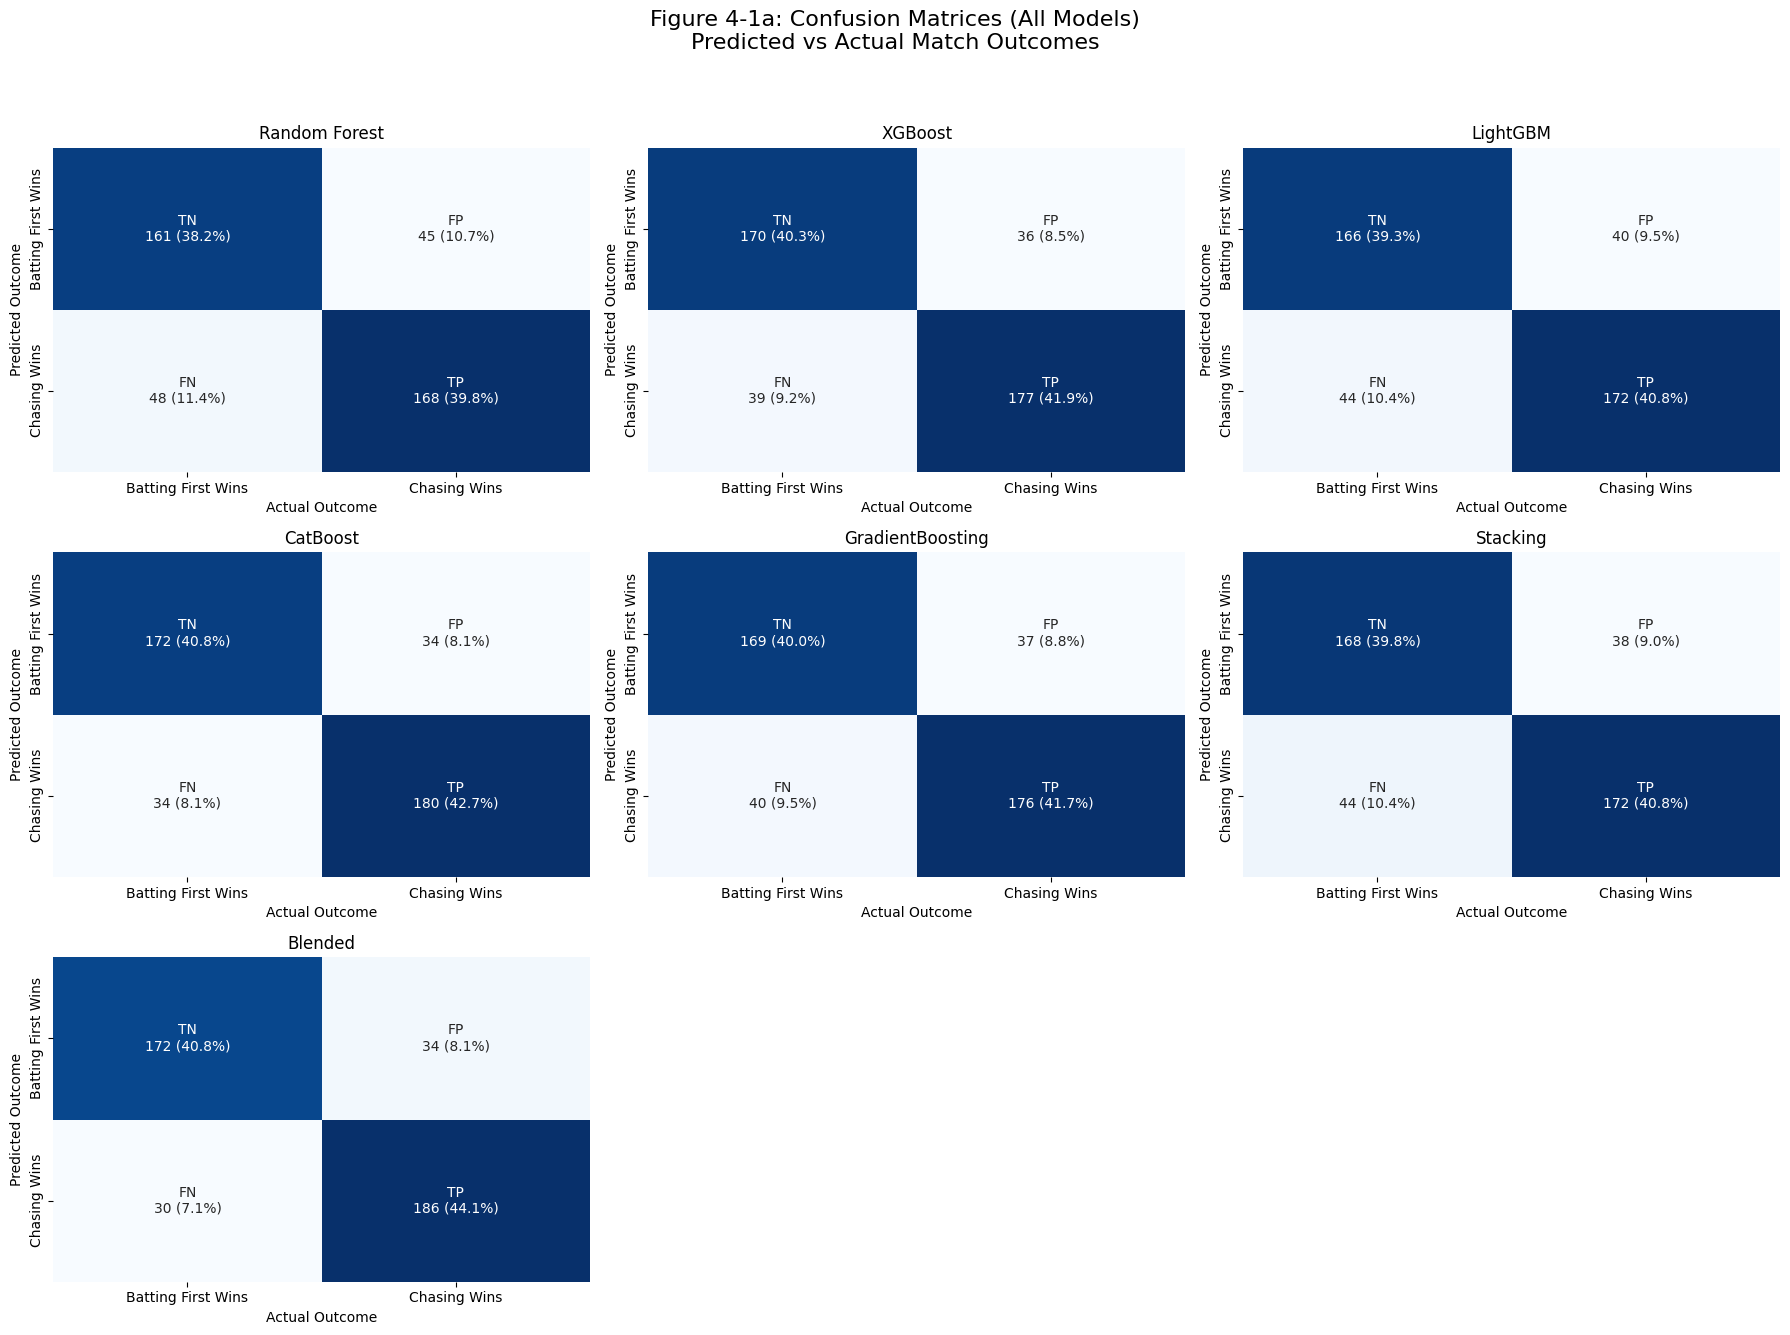

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define model confusion matrix values (TN, FP, FN, TP) and model names
model_results = {
    "Random Forest":      [161, 45, 48, 168],
    "XGBoost":            [170, 36, 39, 177],
    "LightGBM":           [166, 40, 44, 172],
    "CatBoost":           [172, 34, 34, 180],
    "GradientBoosting":   [169, 37, 40, 176],
    "Stacking":           [168, 38, 44, 172],
    "Blended":            [172, 34, 30, 186]
}

total = 422

# Create subplot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# Plot each confusion matrix
for i, (model, values) in enumerate(model_results.items()):
    TN, FP, FN, TP = values
    cm = np.array([[TN, FP], [FN, TP]])
    labels = np.array([
        [f'TN\n{TN} ({TN/total:.1%})', f'FP\n{FP} ({FP/total:.1%})'],
        [f'FN\n{FN} ({FN/total:.1%})', f'TP\n{TP} ({TP/total:.1%})']
    ])
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, ax=axes[i],
                xticklabels=['Batting First Wins', 'Chasing Wins'],
                yticklabels=['Batting First Wins', 'Chasing Wins'])
    axes[i].set_title(model)
    axes[i].set_xlabel('Actual Outcome')
    axes[i].set_ylabel('Predicted Outcome')

# Hide unused subplots if any
for j in range(len(model_results), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Figure 4-1a: Confusion Matrices (All Models)\nPredicted vs Actual Match Outcomes", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


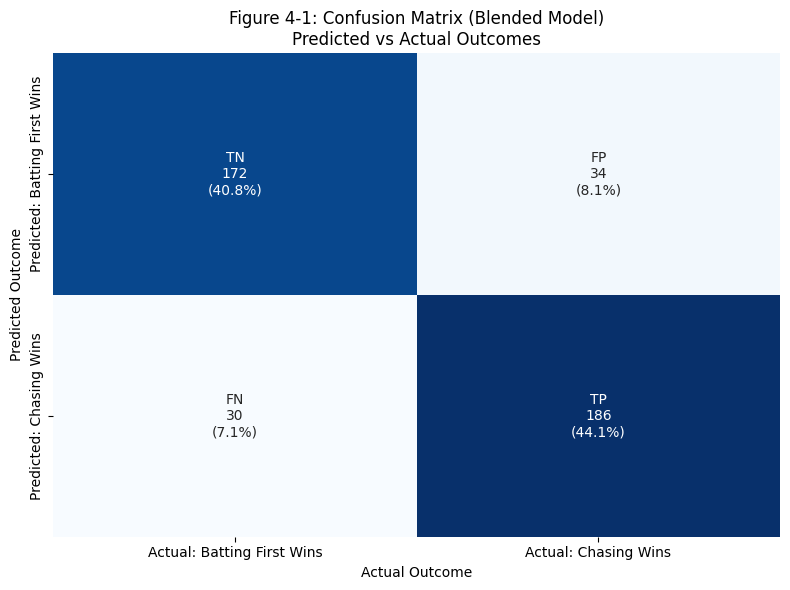

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Simulated blended model confusion matrix values
# Format: [[True Negative, False Positive], [False Negative, True Positive]]
conf_matrix = np.array([[172, 34], [30, 186]])  # Example counts from your HTML

# Convert to percentage
conf_matrix_percent = (conf_matrix / np.sum(conf_matrix)) * 100
labels = np.array([
    [f'TN\n{conf_matrix[0,0]}\n({conf_matrix_percent[0,0]:.1f}%)', f'FP\n{conf_matrix[0,1]}\n({conf_matrix_percent[0,1]:.1f}%)'],
    [f'FN\n{conf_matrix[1,0]}\n({conf_matrix_percent[1,0]:.1f}%)', f'TP\n{conf_matrix[1,1]}\n({conf_matrix_percent[1,1]:.1f}%)']
])

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Actual: Batting First Wins', 'Actual: Chasing Wins'],
            yticklabels=['Predicted: Batting First Wins', 'Predicted: Chasing Wins'])
plt.title('Figure 4-1: Confusion Matrix (Blended Model)\nPredicted vs Actual Outcomes')
plt.xlabel('Actual Outcome')
plt.ylabel('Predicted Outcome')
plt.tight_layout()
plt.show()


C:\Users\gauti\AppData\Local\Temp\ipykernel_15292\3354081001.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x="team", y="titles", palette=colors)


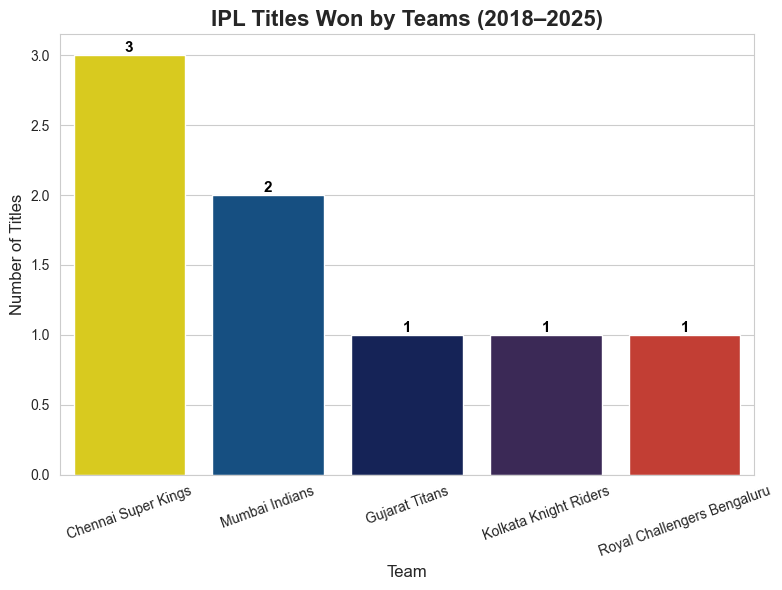

In [2]:
# Custom vertical bar chart with IPL team colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
teams = ["Chennai Super Kings", "Mumbai Indians", "Gujarat Titans", "Kolkata Knight Riders", "Royal Challengers Bengaluru"]
titles = [3, 2, 1, 1, 1]
data = pd.DataFrame({"team": teams, "titles": titles})

# Define official-like team colors
team_colors = {
    "Chennai Super Kings": "#F7E400",   # Yellow
    "Mumbai Indians": "#045093",        # Blue
    "Gujarat Titans": "#0A1D62",        # Dark Blue
    "Kolkata Knight Riders": "#3A225D", # Purple
    "Royal Challengers Bengaluru": "#DA291C" # Red
}

# Map colors
colors = [team_colors[t] for t in data["team"]]

# Plot
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
ax = sns.barplot(data=data, x="team", y="titles", palette=colors)

# Titles and labels
plt.title("IPL Titles Won by Teams (2018–2025)", fontsize=16, fontweight="bold")
plt.xlabel("Team", fontsize=12)
plt.ylabel("Number of Titles", fontsize=12)

# Add annotations
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=11, fontweight="bold", color="black")

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


C:\Users\gauti\AppData\Local\Temp\ipykernel_15292\1496339218.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bat_first, y="team", x="win_pct", palette="Reds_r", ax=axes[0])
C:\Users\gauti\AppData\Local\Temp\ipykernel_15292\1496339218.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=chasing, y="team", x="win_pct", palette="Greens", ax=axes[1])


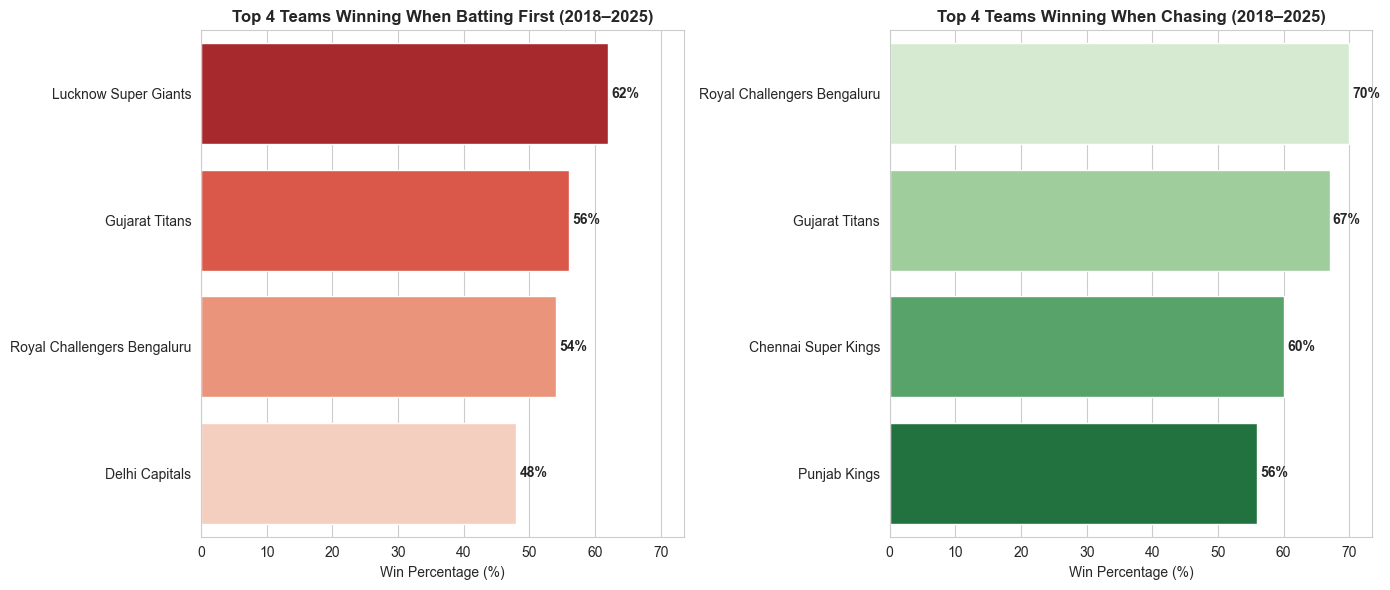

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data extracted from the charts you shared
bat_first = pd.DataFrame({
    "team": ["Lucknow Super Giants", "Gujarat Titans", "Royal Challengers Bengaluru", "Delhi Capitals"],
    "win_pct": [62, 56, 54, 48]
})

chasing = pd.DataFrame({
    "team": ["Royal Challengers Bengaluru", "Gujarat Titans", "Chennai Super Kings", "Punjab Kings"],
    "win_pct": [70, 67, 60, 56]
})

# =================== Combined Side-by-Side Chart ===================
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True)

sns.set_style("whitegrid")

# Batting first chart
sns.barplot(data=bat_first, y="team", x="win_pct", palette="Reds_r", ax=axes[0])
axes[0].set_title("Top 4 Teams Winning When Batting First (2018–2025)", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Win Percentage (%)")
axes[0].set_ylabel("")
for i, row in bat_first.iterrows():
    axes[0].text(row["win_pct"]+0.5, i, f"{row['win_pct']}%", va="center", fontsize=10, fontweight="bold")

# Chasing chart
sns.barplot(data=chasing, y="team", x="win_pct", palette="Greens", ax=axes[1])
axes[1].set_title("Top 4 Teams Winning When Chasing (2018–2025)", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Win Percentage (%)")
axes[1].set_ylabel("")
for i, row in chasing.iterrows():
    axes[1].text(row["win_pct"]+0.5, i, f"{row['win_pct']}%", va="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()
